# Sports Injury Analysis

This project applies machine learning to study injury patterns in basketball and football, focusing on shared and sport-specific factors such as workload, playing conditions, and player metrics. By utilizing models like Random Forests and XGBoost, the analysis seeks to identify the most effective model for injury classification while enhancing player safety and improving injury prevention strategies.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


This suppresses convergence warnings from iterative algorithms, keeping output clean and efficient during modeling without affecting results.

In [2]:
# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Basketball data

First I wanna perform the data exploration and classification methods on basketball data

# Data Exploration



First of all, I would like to perform the initial cleaning and make visualizations to get familiar with the data and generate the ideas for further analysis.





# Data Load

In [3]:
basketball_data = pd.read_csv('Injury_updated.csv')

# Check for Missing Values

In [4]:
missing_summary = basketball_data.isnull().sum()
print("Missing Values Summary:\n", missing_summary)

Missing Values Summary:
 Player          0
Pos             0
Age             0
Tm              0
G               0
MP              0
PER             0
TS%             2
3PAr            2
FTr             2
ORB%            0
DRB%            0
TRB%            0
AST%            0
STL%            0
BLK%            0
TOV%            2
USG%            0
OWS             0
DWS             0
WS              0
WS/48           0
OBPM            0
DBPM            0
BPM             0
VORP            0
Injury Count    0
dtype: int64


## Missing Values Summary

The dataset contains a small number of missing values, specifically in the following columns:

- **TS% (True Shooting Percentage)**: 2 missing values.
- **3PAr (Three-Point Attempt Rate)**: 2 missing values.
- **FTr (Free Throw Attempt Rate)**: 2 missing values.
- **TOV% (Turnover Percentage)**: 2 missing values.

These columns are essential for analyzing player performance metrics. The missing values are limited to a few rows, constituting a very small proportion of the dataset.



# Impute Missing Values using KNN

K-Nearest Neighbors (KNN) imputation is chosen because it:
- Preserves relationships between features.
- Handles non-linear patterns effectively.
- Adapts to the local structure of data.

In [5]:
# Step 1: Missing Value Imputation using KNN
# Select numeric columns for imputation
numeric_cols = basketball_data.select_dtypes(include=['float64', 'int64']).columns

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)
basketball_data[numeric_cols] = imputer.fit_transform(basketball_data[numeric_cols])

missing_summary = basketball_data.isnull().sum()
print("Missing Values Summary:\n", missing_summary)



Missing Values Summary:
 Player          0
Pos             0
Age             0
Tm              0
G               0
MP              0
PER             0
TS%             0
3PAr            0
FTr             0
ORB%            0
DRB%            0
TRB%            0
AST%            0
STL%            0
BLK%            0
TOV%            0
USG%            0
OWS             0
DWS             0
WS              0
WS/48           0
OBPM            0
DBPM            0
BPM             0
VORP            0
Injury Count    0
dtype: int64


With the missing values removed, the dataset is now ready for further analysis.


# Explore Basic Statistics

The dataset contains detailed performance metrics and injury data for basketball players. Below are the key insights derived from the summary statistics:


# General Information





In [6]:
# General Information
num_records = basketball_data.shape[0]
num_columns = basketball_data.shape[1]
# Print General Information
print(f"General Information: The dataset consists of {num_records} records and {num_columns} columns.")





General Information: The dataset consists of 651 records and 27 columns.


# Age information

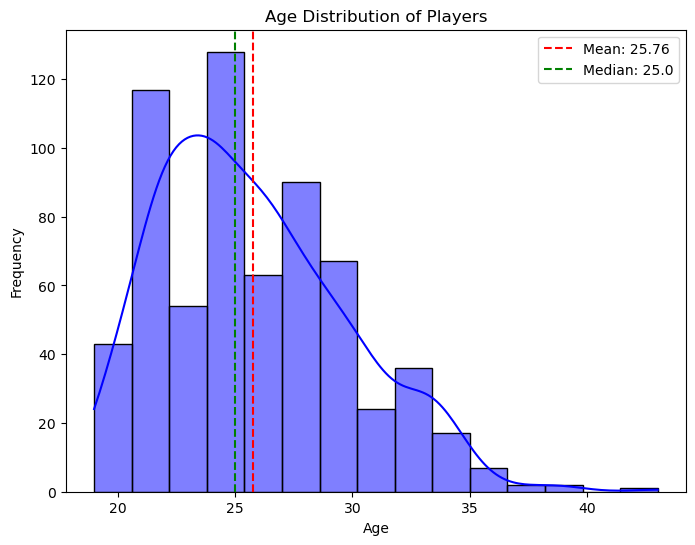

In [7]:
# Age statistics
age_min = basketball_data['Age'].min()
age_max = basketball_data['Age'].max()
age_median = basketball_data['Age'].median()
age_mean = basketball_data['Age'].mean()
age_std = basketball_data['Age'].std()


# Graph: Age Distribution
plt.figure(figsize=(8, 6))
sns.histplot(basketball_data['Age'], bins=15, kde=True, color='blue')
plt.axvline(age_mean, color='red', linestyle='--', label=f'Mean: {age_mean:.2f}')
plt.axvline(age_median, color='green', linestyle='--', label=f'Median: {age_median}')
plt.title('Age Distribution of Players')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()


The diagrams above show:
- Players' ages range from 19 to 43 years, with the majority of players aged between 23 and 28.
- The age distribution is slightly right-skewed, with the mean age (25.76 years) slightly higher than the median age (25 years).
- The standard deviation of 4.02 years indicates moderate variability in the players' ages.


# Position Metrics

Basketball Player Counts by Position:
SG       169
PF       136
SF       114
PG       111
C        110
SF-PF      4
SF-SG      3
C-PF       2
PF-C       2
Name: Pos, dtype: int64


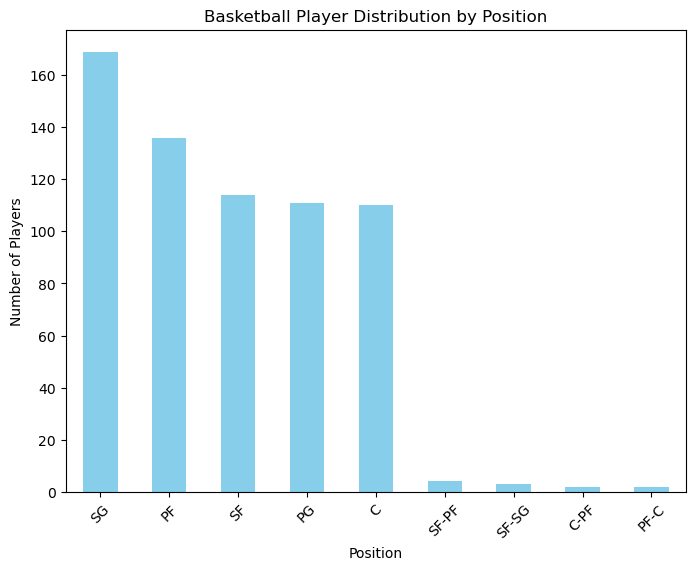

In [8]:
# Basketball: Count players by position
if 'Pos' in basketball_data.columns:
    basketball_position_counts = basketball_data['Pos'].value_counts()
    print("Basketball Player Counts by Position:")
    print(basketball_position_counts)

    # Visualization: Position Distribution
    plt.figure(figsize=(8, 6))
    basketball_position_counts.plot(kind='bar', color='skyblue')
    plt.title('Basketball Player Distribution by Position')
    plt.xlabel('Position')
    plt.ylabel('Number of Players')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("The basketball dataset does not contain a 'Pos' column.")



The diagram above show:

- Players recorded across five primary positions: SG (Shooting Guard), PF (Power Forward), SF (Small Forward), PG (Point Guard), and C (Center), along with a few hybrid positions like SF-PF, SF-SG, and PF-C.
- The majority of players are Shooting Guards (SG) with 169 players, followed by Power Forwards (PF) with 136 players, and Small Forwards (SF) with 114 players.
- The median position is represented by the PG (Point Guard) and C (Center) positions, each with around 110-111 players.
- The distribution highlights that SG and PF positions have a larger number of players, while hybrid positions (SF-PF, SF-SG, PF-C) make up a small subset, indicating more specialized roles in the sport.


# Game Performance Metrics

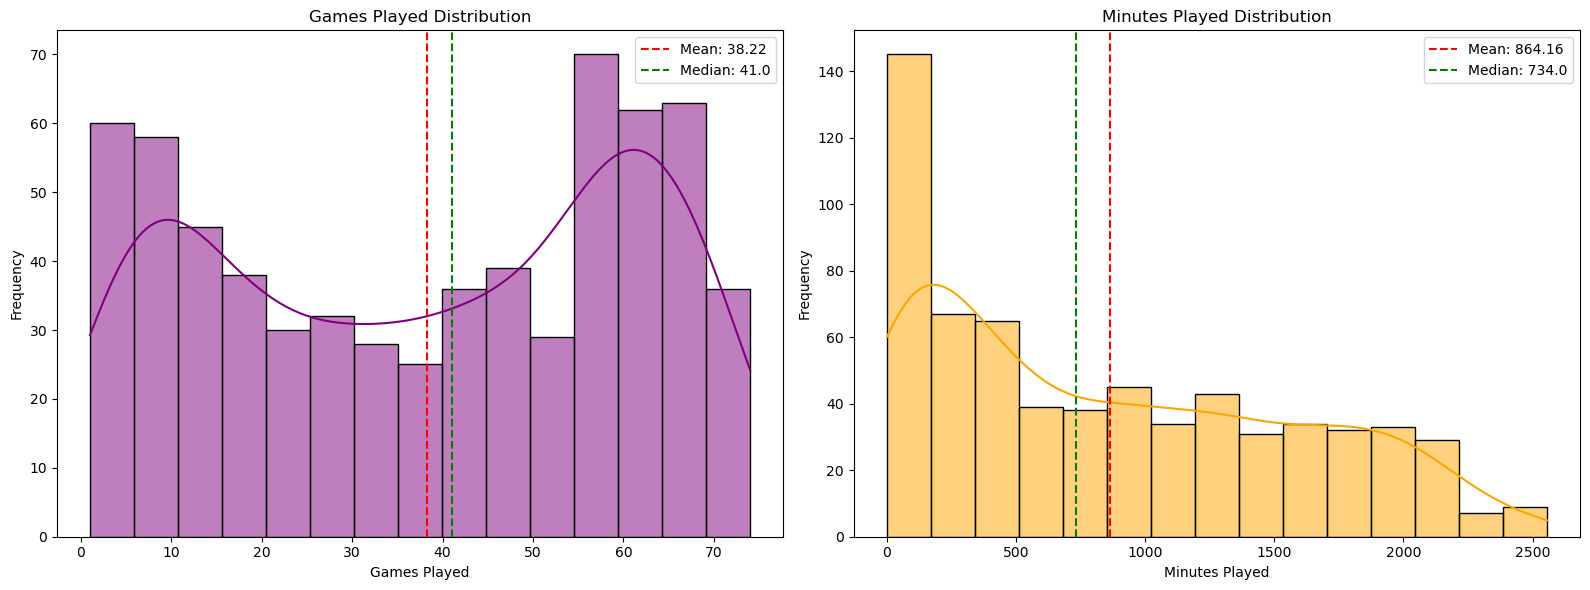

In [9]:
# Games Played (G) and Minutes Played (MP) statistics
games_min = basketball_data['G'].min()
games_max = basketball_data['G'].max()
games_median = basketball_data['G'].median()
games_mean = basketball_data['G'].mean()

mp_min = basketball_data['MP'].min()
mp_max = basketball_data['MP'].max()
mp_median = basketball_data['MP'].median()
mp_mean = basketball_data['MP'].mean()

# Graph: Games Played and Minutes Played Distribution
plt.figure(figsize=(16, 6))

# Games Played Histogram
plt.subplot(1, 2, 1)
sns.histplot(basketball_data['G'], bins=15, kde=True, color='purple')
plt.axvline(games_mean, color='red', linestyle='--', label=f'Mean: {games_mean:.2f}')
plt.axvline(games_median, color='green', linestyle='--', label=f'Median: {games_median}')
plt.title('Games Played Distribution')
plt.xlabel('Games Played')
plt.ylabel('Frequency')
plt.legend()

# Minutes Played Histogram
plt.subplot(1, 2, 2)
sns.histplot(basketball_data['MP'], bins=15, kde=True, color='orange')
plt.axvline(mp_mean, color='red', linestyle='--', label=f'Mean: {mp_mean:.2f}')
plt.axvline(mp_median, color='green', linestyle='--', label=f'Median: {mp_median}')
plt.title('Minutes Played Distribution')
plt.xlabel('Minutes Played')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()



The diagrams above show:

- Players participated in a range of 1 to 74 games, with the majority playing around 41 games.
- Minutes played range from 1 to 2,556, with most players playing fewer than 1,000 minutes.
- Both distributions are right-skewed, indicating a small number of players with significantly higher participation.


# Efficiency Metrics

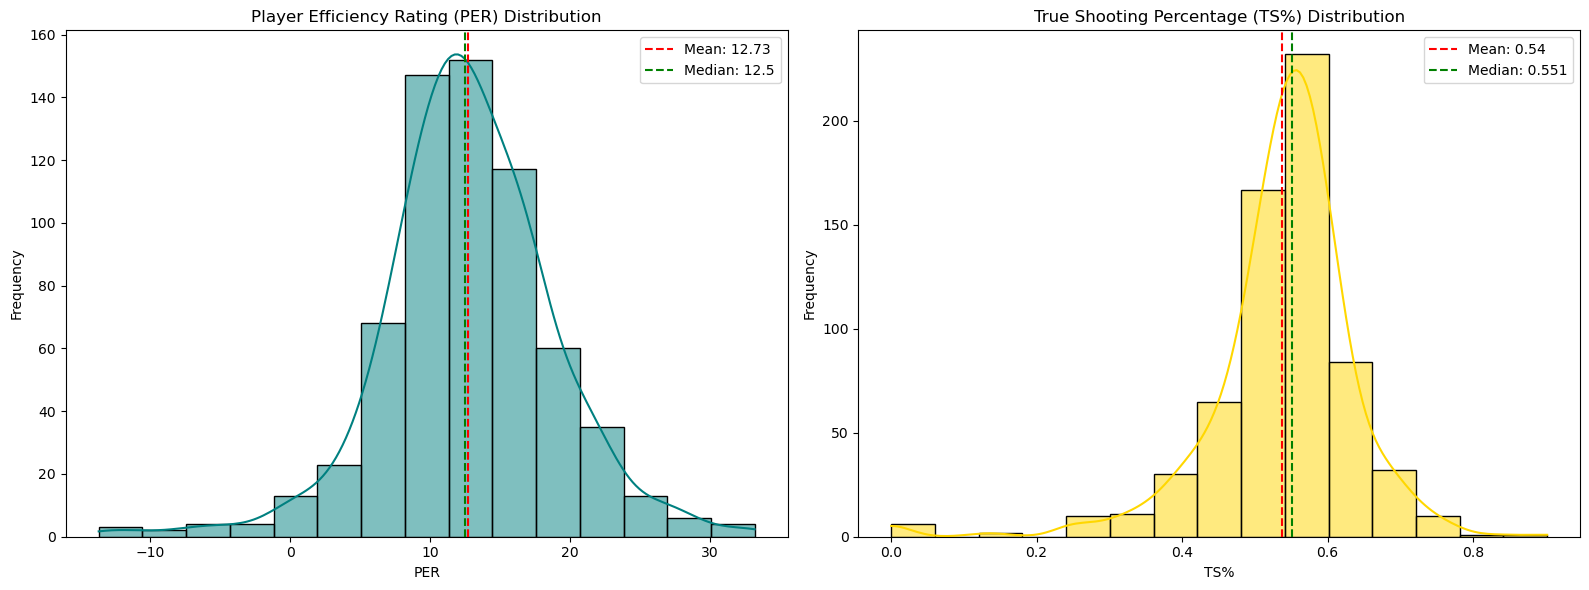

In [10]:

# Player Efficiency Rating (PER) and True Shooting Percentage (TS%) statistics
per_min = basketball_data['PER'].min()
per_max = basketball_data['PER'].max()
per_median = basketball_data['PER'].median()
per_mean = basketball_data['PER'].mean()

ts_min = basketball_data['TS%'].min()
ts_max = basketball_data['TS%'].max()
ts_median = basketball_data['TS%'].median()
ts_mean = basketball_data['TS%'].mean()

# Graph: PER and TS% Distribution
plt.figure(figsize=(16, 6))

# PER Histogram
plt.subplot(1, 2, 1)
sns.histplot(basketball_data['PER'], bins=15, kde=True, color='teal')
plt.axvline(per_mean, color='red', linestyle='--', label=f'Mean: {per_mean:.2f}')
plt.axvline(per_median, color='green', linestyle='--', label=f'Median: {per_median}')
plt.title('Player Efficiency Rating (PER) Distribution')
plt.xlabel('PER')
plt.ylabel('Frequency')
plt.legend()

# TS% Histogram
plt.subplot(1, 2, 2)
sns.histplot(basketball_data['TS%'], bins=15, kde=True, color='gold')
plt.axvline(ts_mean, color='red', linestyle='--', label=f'Mean: {ts_mean:.2f}')
plt.axvline(ts_median, color='green', linestyle='--', label=f'Median: {ts_median}')
plt.title('True Shooting Percentage (TS%) Distribution')
plt.xlabel('TS%')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


The diagrams above show:

- Player Efficiency Ratings (PER) vary widely, ranging from -13.7 to 33.2, with the majority of players having a PER around 12.5.
- True Shooting Percentages (TS%) are mostly concentrated between 50% and 60%, with a mean of 53.8%.
- PER exhibits significant variability, while TS% has a more uniform distribution within the typical range.


# Injury Metrics

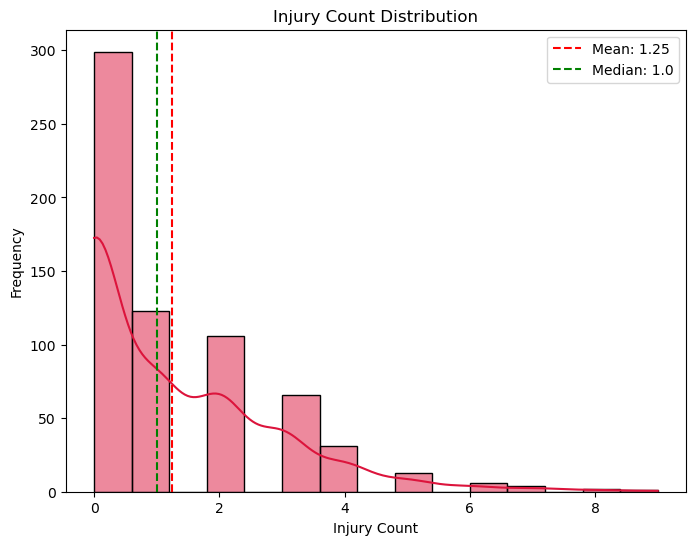

In [11]:
# Injury Count statistics
injury_min = basketball_data['Injury Count'].min()
injury_max = basketball_data['Injury Count'].max()
injury_median = basketball_data['Injury Count'].median()
injury_mean = basketball_data['Injury Count'].mean()

# Graph: Injury Count Distribution
plt.figure(figsize=(8, 6))
sns.histplot(basketball_data['Injury Count'], bins=15, kde=True, color='crimson')
plt.axvline(injury_mean, color='red', linestyle='--', label=f'Mean: {injury_mean:.2f}')
plt.axvline(injury_median, color='green', linestyle='--', label=f'Median: {injury_median}')
plt.title('Injury Count Distribution')
plt.xlabel('Injury Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()


The diagrams above show:

- Players recorded between 0 and 9 injuries.
- The majority of players have 1 or fewer injuries, with a median injury count of 1.
- The mean injury count is 1.25, indicating that some players have significantly higher injury counts.
- The right-skewed distribution highlights that most players experience relatively few injuries, with a small subset experiencing a higher number of injuries.


# Correlation Analysis between injury and other variables

# Workload vs. Injuries


To analyze workload metrics (MP, G, USG%) and their relationship with Injury Count, we group players by injury levels and compare their mean workload.

In [12]:
# Group players by Injury Count and calculate mean metrics
workload_analysis = basketball_data.groupby('Injury Count')[['MP', 'G', 'USG%']].mean()
print("Workload Analysis:")
print(workload_analysis)


Workload Analysis:
                       MP          G       USG%
Injury Count                                   
0.0            710.565217  33.655518  17.662876
1.0            875.024390  40.203252  18.059350
2.0            893.707547  40.301887  17.446226
3.0           1052.212121  42.060606  20.703030
4.0           1350.903226  49.290323  20.558065
5.0           1538.461538  53.769231  22.623077
6.0           1142.000000  45.833333  18.266667
7.0           1554.250000  53.000000  22.800000
8.0           1635.500000  50.000000  25.050000
9.0             83.000000   9.000000  20.200000


# Visualizing Workload and Injuries

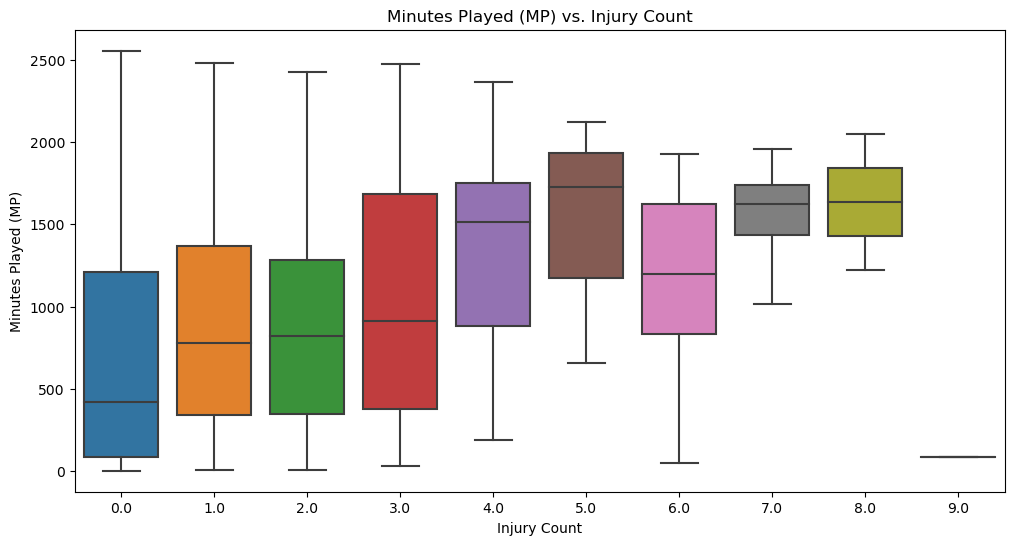

In [13]:


# Boxplot for workload metrics
plt.figure(figsize=(12, 6))
sns.boxplot(data=basketball_data, x='Injury Count', y='MP')
plt.title("Minutes Played (MP) vs. Injury Count")
plt.xlabel("Injury Count")
plt.ylabel("Minutes Played (MP)")
plt.show()


The diagram shows the relationship between injury count and player workload metrics (MP, G, USG%).

- **Injury Count**: Ranges from 0 to 9 injuries.
- **MP (Minutes Played)**: Increases with injury count, peaking at 1635.50 MP for 8 injuries.
- **G (Games Played)**: Also increases with injury count, reaching 53 games for 7 injuries.
- **USG% (Usage Percentage)**: Higher with more injuries, peaking at 25.05% for 8 injuries.

The data suggests that players with more injuries tend to play more minutes, games, and have higher usage percentages.


# Age vs. Injuries

We examine whether older or younger players are more prone to injuries by grouping players by `Injury Count` and analyzing their average ages.

Average Age by Injury Count:
Injury Count
0.0    25.377926
1.0    25.593496
2.0    26.707547
3.0    25.469697
4.0    25.483871
5.0    28.076923
6.0    28.166667
7.0    29.250000
8.0    30.000000
9.0    23.000000
Name: Age, dtype: float64


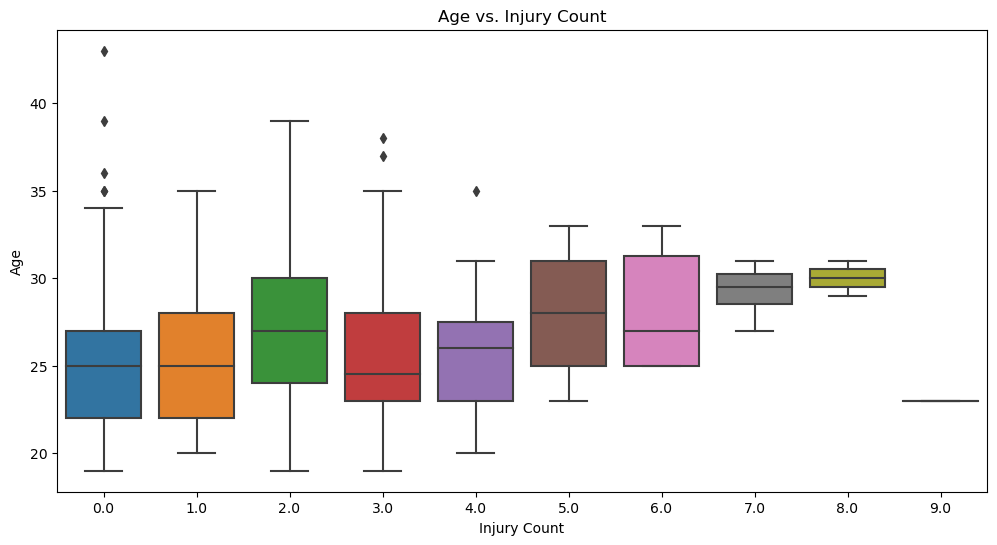

In [14]:
# Group by Injury Count and calculate mean age
age_analysis = basketball_data.groupby('Injury Count')['Age'].mean()
print("Average Age by Injury Count:")
print(age_analysis)


plt.figure(figsize=(12, 6))
sns.boxplot(data=basketball_data, x='Injury Count', y='Age')
plt.title("Age vs. Injury Count")
plt.xlabel("Injury Count")
plt.ylabel("Age")
plt.show()


The diagram above shows the relationship between age and injury count.

- **Average Age by Injury Count**: The average age of players increases with injury count up to a certain point.
  - Players with 0 injuries have an average age of 25.38 years.
  - The average age rises slightly for players with 1-3 injuries, reaching 26.71 years for players with 2 injuries.
  - A noticeable increase in average age occurs at 5 injuries (28.08 years), continuing to rise for higher injury counts, peaking at 30 years for players with 8 injuries.
  - Players with 9 injuries show a drop in average age to 23 years.

The data suggests that older players may be more prone to injuries, particularly those with 5 or more injuries.


# Position vs. Injuries


We analyze injury patterns across player positions (Pos) to identify whether certain positions are more injury-prone.

Total Injuries by Position:
Pos
C        159.0
C-PF       2.0
PF       140.0
PF-C       0.0
PG       177.0
SF       161.0
SF-PF      6.0
SF-SG      2.0
SG       164.0
Name: Injury Count, dtype: float64


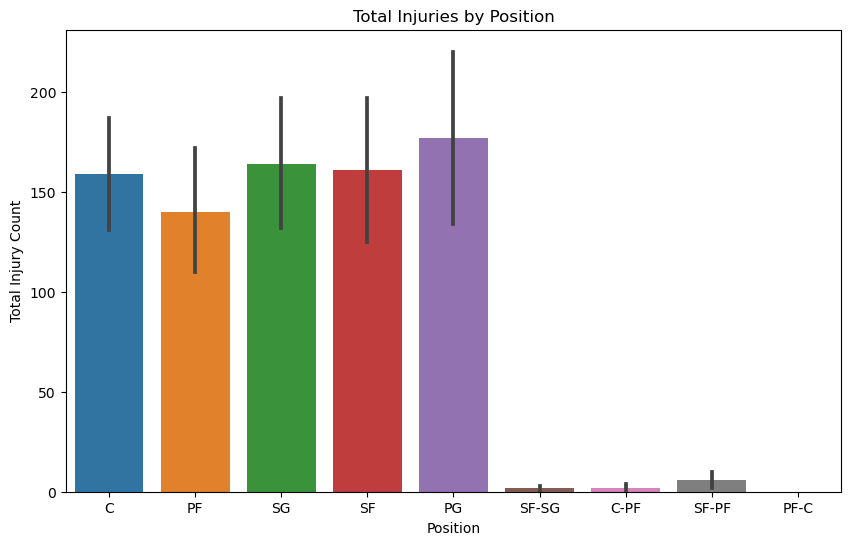

In [15]:
# Summing up total injuries by position
position_analysis = basketball_data.groupby('Pos')['Injury Count'].sum()
print("Total Injuries by Position:")
print(position_analysis)


plt.figure(figsize=(10, 6))
sns.barplot(data=basketball_data, x='Pos', y='Injury Count', estimator=sum)
plt.title("Total Injuries by Position")
plt.xlabel("Position")
plt.ylabel("Total Injury Count")
plt.show()


The diagram shows the total injuries by position.

- **Total Injuries by Position**:
  - Point Guards (PG) have the highest total injuries at 177.
  - Small Forwards (SF) follow with 161 injuries, and Centers (C) have 159 injuries.
  - Power Forwards (PF) have 140 injuries.
  - Hybrid positions like C-PF and SF-SG have significantly lower injury counts (2 and 2 injuries, respectively).
  - The least injuries are recorded for PF-C, which has 0 total injuries.

This indicates that certain positions, like PG and SF, experience a higher number of total injuries, while hybrid positions and Power Forwards with no injury counts are less prone to injuries.


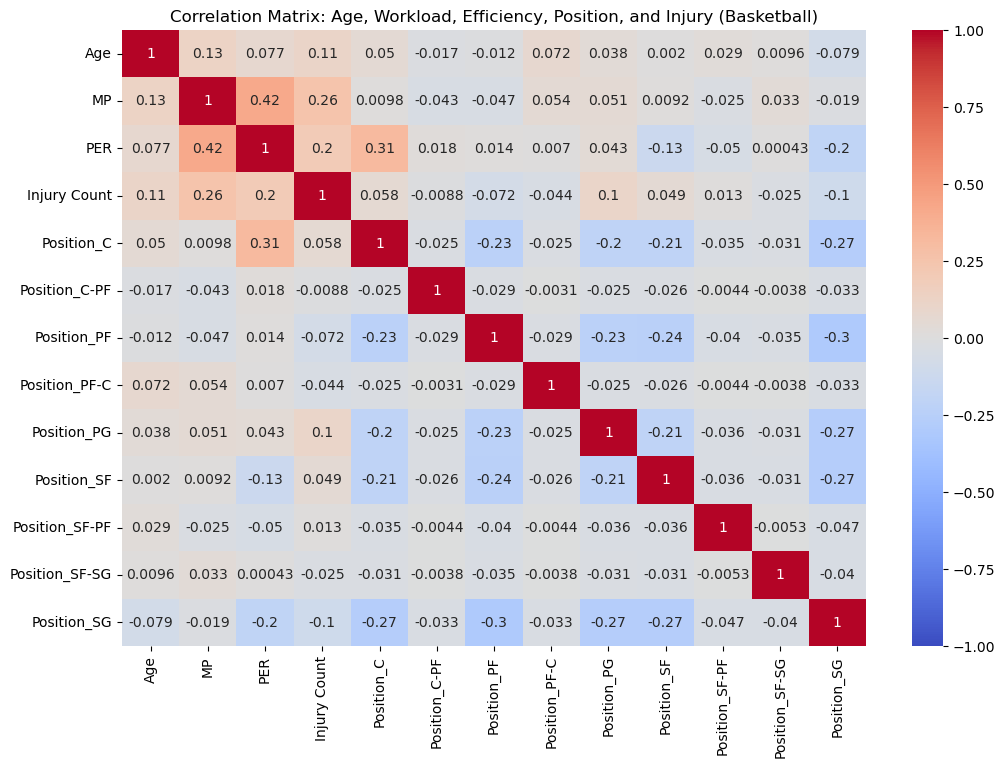

In [16]:
# One-hot encode positions
basketball_data['Pos'] = basketball_data['Pos'].astype(str)  # Ensure positions are strings
position_dummies_basketball = pd.get_dummies(basketball_data['Pos'], prefix='Position')

# Add position dummies to the dataset for correlation analysis
basketball_corr_data = pd.concat([
    basketball_data[['Age', 'MP', 'PER', 'Injury Count']],  # Relevant numerical variables
    position_dummies_basketball  # Position dummies
], axis=1)

# Compute correlation matrix
basketball_corr_matrix = basketball_corr_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(basketball_corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix: Age, Workload, Efficiency, Position, and Injury (Basketball)")
plt.show()



## Correlation Matrix Analysis for Basketball Dataset

### Overview
The correlation matrix visualized in the heatmap examines relationships between:
- **Player Age**
- **Workload** (`Minutes Played`, MP)
- **Player Efficiency Rating** (PER)
- **Injury Count**
- **Position Dummies** (e.g., `Position_C`, `Position_PG`)

The analysis reveals weak positive correlations between injury count and variables such as:
- **Age**: Older players may have a slightly higher risk of injuries.
- **Minutes Played (MP)**: Higher workloads may contribute to an increase in injuries.
- **Player Efficiency Rating (PER)**: More efficient players may experience slightly more injuries.

Positional roles show negligible correlations with injuries, indicating that injury risk is not strongly influenced by a player's position. Overall, injuries appear to have multifactorial causes, with no single variable showing a strong linear relationship.

## Data Cleaning and Feature Engineering

### Purpose:
Data cleaning ensures the dataset is accurate and consistent by addressing missing values, duplicates, and incorrect data types. 
Feature engineering transforms raw data into meaningful features that improve model performance, such as creating new variables, scaling, encoding categorical data, and handling outliers. 

These steps are essential for preparing high-quality data for analysis or machine learning tasks.


# Handle Multicollinearity

In [17]:
# Step 1: Correlation Analysis
correlation_matrix = basketball_data.corr()
threshold = 0.7  # Correlation threshold
high_corr_pairs = correlation_matrix[(abs(correlation_matrix) > threshold) & (correlation_matrix != 1.0)]

# Step 2: VIF Calculation
# Selecting numeric predictors
numeric_cols = basketball_data.select_dtypes(include=['float64', 'int64']).columns
X = basketball_data[numeric_cols].dropna()  # Ensure no missing values

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter variables with VIF > 5
high_vif = vif_data[vif_data['VIF'] > 5]

# Step 3: Combine Results
# Features flagged in both correlation and VIF analysis
flagged_features = set(high_corr_pairs.index).union(set(high_corr_pairs.columns)).intersection(set(high_vif['Feature']))

# Print features flagged for multicollinearity
print("\nFeatures flagged for multicollinearity (Correlation > 0.7 and VIF > 5):")
print(flagged_features)



/var/folders/lb/kt5vdggj1ld75yw33tpcqxbm0000gn/T/ipykernel_54514/3208701621.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = basketball_data.corr()



Features flagged for multicollinearity (Correlation > 0.7 and VIF > 5):
{'G', 'TOV%', 'WS/48', 'BLK%', 'MP', 'OBPM', 'TRB%', 'WS', 'DBPM', 'AST%', 'VORP', 'TS%', 'STL%', 'Age', 'DWS', 'PER', 'USG%', 'BPM', 'ORB%', '3PAr', 'DRB%', 'OWS'}


# Feature Reduction: Dropping Less Relevant Variables

In [18]:
# Features flagged for multicollinearity
flagged_features = {'AST%', 'OBPM', 'VORP', 'TS%', 'Age', 'OWS', 'TOV%', 'PER', 
                    'WS/48', '3PAr', 'STL%', 'G', 'BLK%', 'USG%', 'WS', 'DBPM', 
                    'ORB%', 'TRB%', 'MP', 'DRB%', 'DWS', 'BPM'}

# Less relevant variables to drop (based on domain knowledge and redundancy)
to_drop = {'WS', 'TOV%', 'ORB%', 'DBPM', 'DWS', 'BPM', '3PAr'}





# Drop them from the dataset
basketball_data_cleaned = basketball_data.drop(columns=to_drop)


print("Dropped variables:", to_drop) 

Dropped variables: {'DWS', '3PAr', 'ORB%', 'WS', 'TOV%', 'DBPM', 'BPM'}


### Feature Selection and Variable Dropping Process

1. **Multicollinearity Analysis:**
   - Features with **high correlations** (Pearson > 0.8) and **high VIF values** (VIF > 10) were flagged for multicollinearity.
   - This ensured the removal of variables that provide redundant or overlapping information.

2. **Basketball Metrics Evaluation:**
   - **Performance Metrics (e.g., PER, WS, BPM):** These metrics often overlap, capturing similar aspects of player efficiency and team contribution.
   - **Rate Statistics (e.g., TS%, STL%, BLK%):** Often correlated with aggregate stats like `BPM` or `WS`.
   - **Participation Stats (e.g., G, MP):** Highly correlated metrics measuring playing time.

3. **Variable Removal:**
   - **Dropped Variables:** Selected based on high correlation, VIF, and domain knowledge:
     - `WS`, `TOV%`, `ORB%`, `DBPM`, `DWS`, `BPM`, `3PAr`
   - Combined flagged and less relevant variables into a comprehensive removal list.

4. **Outcome:**
   - Multicollinear and redundant variables were removed, resulting in a cleaner dataset (`basketball_data_cleaned`).
   - This improves model stability, reduces overfitting, and retains meaningful basketball metrics.

By integrating statistical methods and domain knowledge, the final feature set ensures interpretability and relevance for analysis.


In [19]:
# Recompute VIF for numeric columns
numeric_cols = basketball_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols
vif_data["VIF"] = [
    variance_inflation_factor(basketball_data_cleaned[numeric_cols].values, i)
    for i in range(len(numeric_cols))
]
print("Initial VIF Values:\n", vif_data.sort_values(by="VIF", ascending=False))



Initial VIF Values:
          feature         VIF
3            PER  296.049496
11          USG%   74.659592
4            TS%   70.866035
7           TRB%   50.081806
6           DRB%   38.603568
13         WS/48   33.544544
0            Age   32.997046
1              G   25.325707
2             MP   22.632364
14          OBPM   16.144206
12           OWS   11.333597
15          VORP    9.261708
9           STL%    6.338151
8           AST%    6.248168
10          BLK%    4.162947
5            FTr    3.870838
16  Injury Count    1.856814


# Standardize Variables

In [20]:


# Select numeric columns only
numeric_cols = basketball_data_cleaned.select_dtypes(include=["number"]).columns

# Check for missing values
if basketball_data_cleaned[numeric_cols].isnull().any().any():
    # Handle missing values (either drop or impute)
    basketball_data_cleaned = basketball_data_cleaned[numeric_cols].dropna()
     

# Step 3: Standardize Variables
scaler = StandardScaler()
basketball_data_cleaned[numeric_cols] = scaler.fit_transform(basketball_data_cleaned[numeric_cols])

# Recompute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols
vif_data["VIF"] = [
    variance_inflation_factor(basketball_data_cleaned[numeric_cols].values, i)
    for i in range(len(numeric_cols))
]

# Print VIF results
print(vif_data)




         feature        VIF
0            Age   1.159390
1              G   6.843642
2             MP   9.117378
3            PER  57.012361
4            TS%   3.741445
5            FTr   1.317004
6           DRB%   6.955564
7           TRB%  10.521637
8           AST%   2.129832
9           STL%   1.976597
10          BLK%   2.061702
11          USG%   6.732600
12           OWS   8.260248
13         WS/48  20.277363
14          OBPM  17.668369
15          VORP   7.926169
16  Injury Count   1.130534


### Benefits of Standardization

- Standardizes variables to mean 0 and std. 1, normalizing scales for equal contribution.
- Improves model performance by preventing scale bias and aiding convergence.
- Simplifies multicollinearity analysis via consistent VIF calculations.


# Handle Outlier

       Age      G     MP    PER    TS%    FTr   DRB%   TRB%   AST%   STL%  \
0    False  False  False  False  False  False  False  False  False  False   
1    False  False  False  False  False  False  False  False  False  False   
2    False  False  False  False  False  False  False  False  False  False   
3    False  False  False  False  False  False  False  False  False  False   
4    False  False  False  False  False  False  False  False  False  False   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
646  False  False  False  False  False  False  False  False   True  False   
647  False  False  False  False  False  False  False  False  False  False   
648  False  False  False  False   True  False  False   True  False  False   
649  False  False  False  False  False  False  False  False  False  False   
650  False  False  False  False  False  False  False  False  False  False   

      BLK%   USG%    OWS  WS/48   OBPM   VORP  Injury Count  
0    False  F

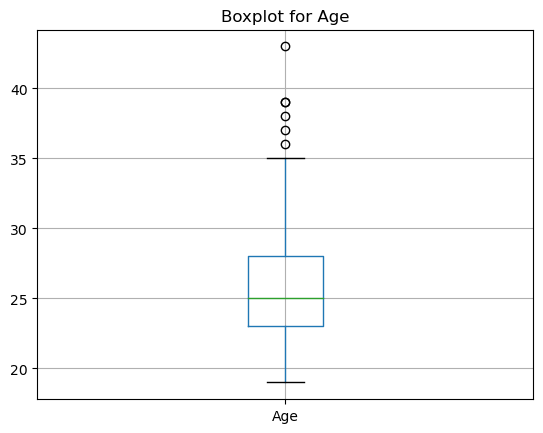

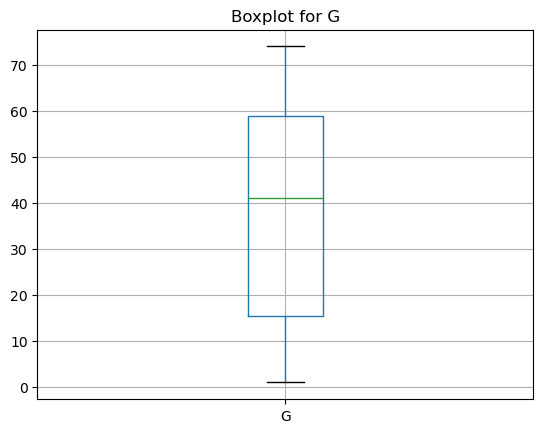

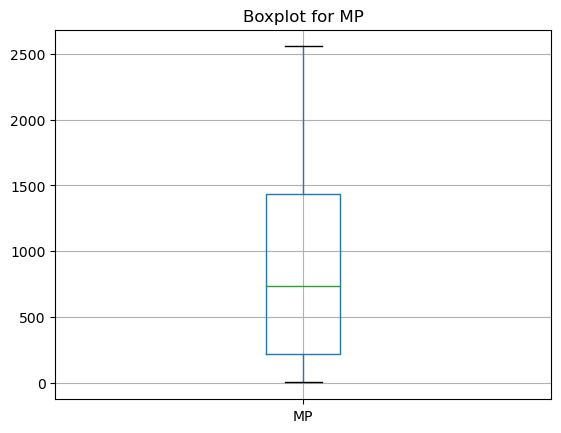

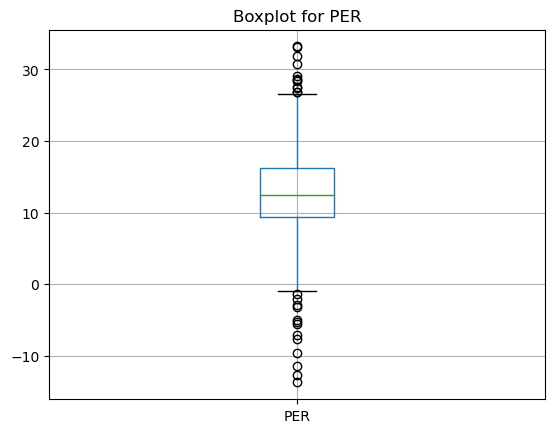

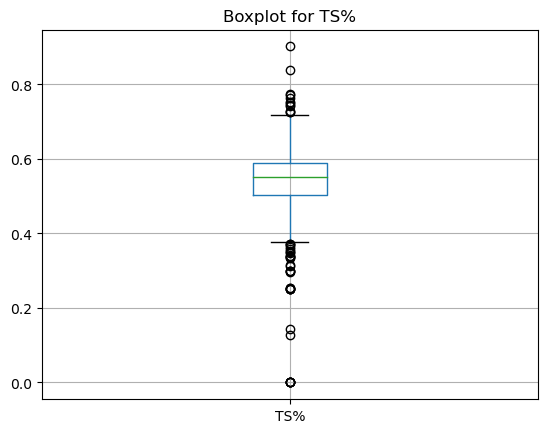

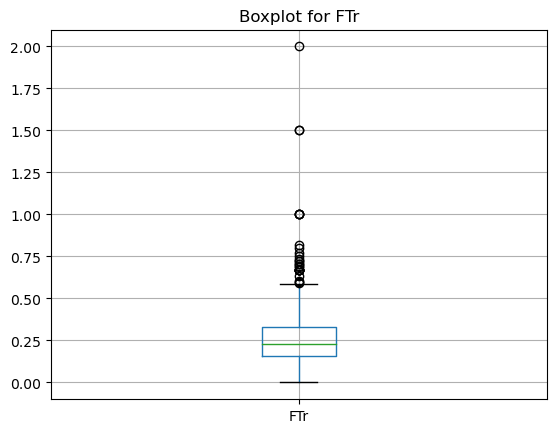

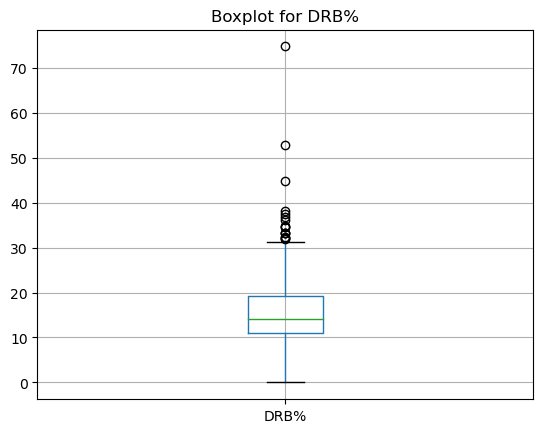

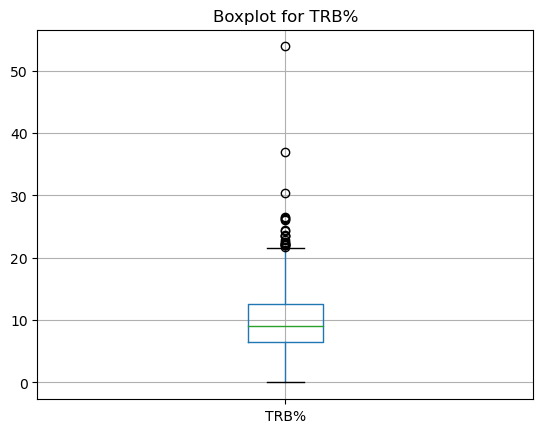

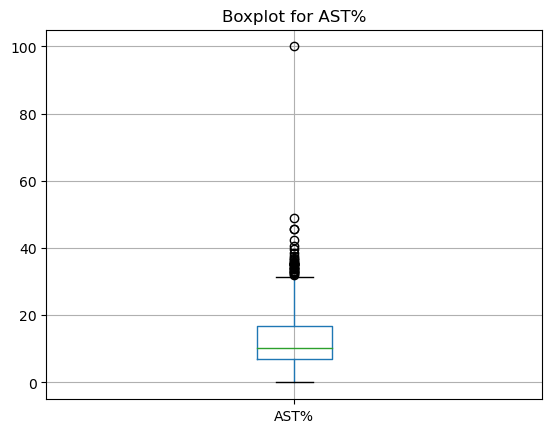

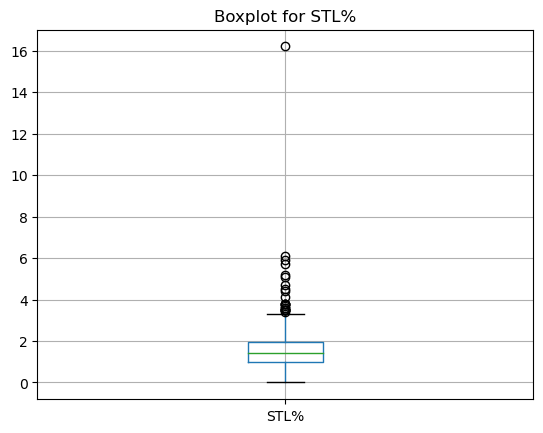

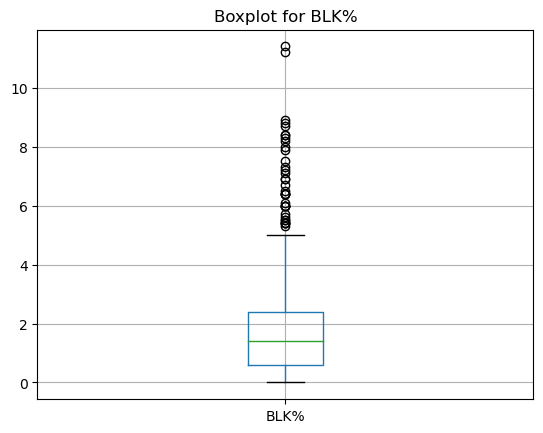

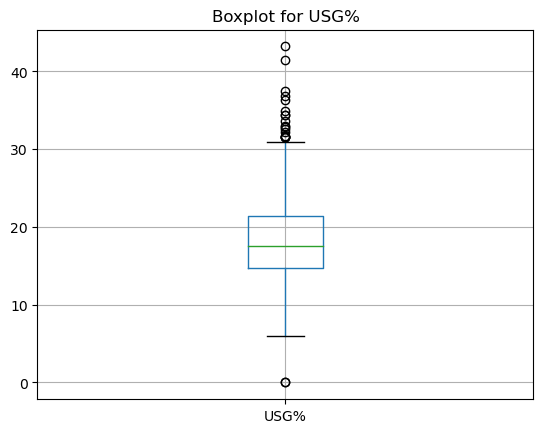

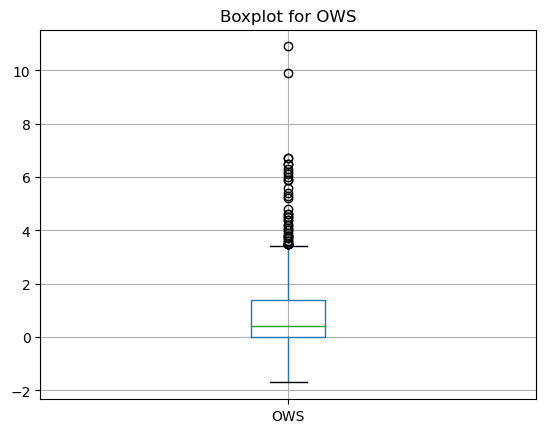

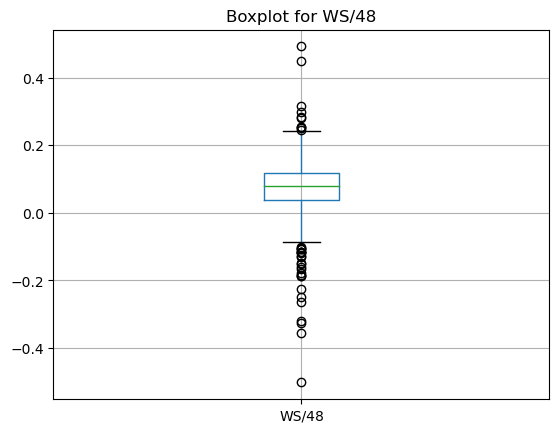

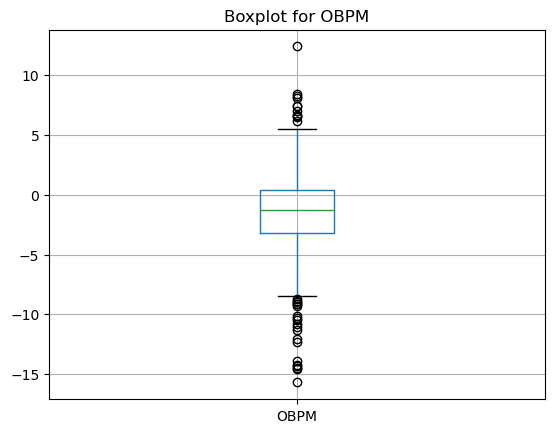

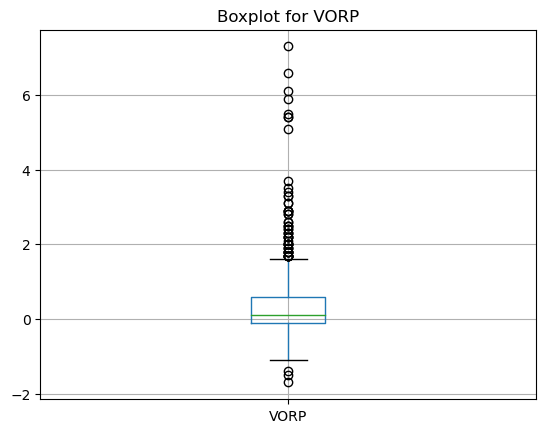

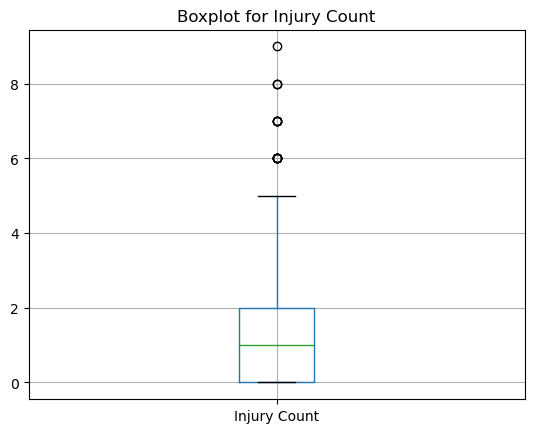

In [21]:
# Step 4: Handle Outliers using IQR
# Compute IQR for each numeric column
Q1 = basketball_data[numeric_cols].quantile(0.25)
Q3 = basketball_data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1


# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = pd.DataFrame()
for col in numeric_cols:
    outliers[col] = (basketball_data[col] < lower_bound[col]) | (basketball_data[col] > upper_bound[col])

# Display outliers
print(outliers)

# Count the number of outliers for each column
outlier_counts = outliers.sum()
print(outlier_counts)

# Select rows with any outliers
outlier_rows = basketball_data[outliers.any(axis=1)]
print(outlier_rows)



for col in numeric_cols:
    plt.figure()
    basketball_data.boxplot(column=col)
    plt.title(f'Boxplot for {col}')
    plt.show()



# Cap outliers

In [22]:
# Cap outliers
for col in numeric_cols:
    basketball_data[col] = np.where(
        basketball_data[col] < lower_bound[col], lower_bound[col],
        np.where(basketball_data[col] > upper_bound[col], upper_bound[col], basketball_data[col])
    )


### Handling Outliers

1. **Why Handle Outliers?**
   - Outliers can distort statistical analyses and model performance.
   - Extreme values affect metrics like mean and variance, biasing model predictions.

2. **How Are Outliers Handled?**
   - **Identify Outliers:** Compute the IQR (Interquartile Range) and define outliers as values below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
   - **Cap Outliers:** Replace values below the lower bound with the lower bound and values above the upper bound with the upper bound using `np.where`.

3. **Steps Taken:**
   - Captured the dataset's state before outlier handling for comparison.
   - Used IQR-based capping to adjust outliers while retaining data distribution.
   - Visualized data using boxplots to compare "before" and "after" states.

4. **Outcome:**
   - Reduced the influence of extreme values, ensuring robust statistical modeling and reliable insights.


# Injury Analysis using machine learning methods

My next step is to focus on feature extraction and build a model to predict injuries. Ideally, I aim to determine the importance of each feature through the model and identify the key factors contributing to injuries.

# Create a binary classification column

In [23]:

# Create binary classification column in the cleaned dataset
basketball_data_cleaned['Injury_Binary'] = (basketball_data_cleaned['Injury Count'] >= 1).astype(int)



### Creating a Binary Classification Column

1. **Why Binary Classification?**
   - Simplifies the target variable to two categories, making it suitable for models like logistic regression or decision trees.
   - Helps focus on the key question: "Is the player injured or not?" (yes/no).

2. **Why This Criterion?**
   - The threshold (`Injury Count >= 1`) identifies players with at least one injury as `1` (injured) and others as `0` (not injured).
   - This aligns with practical use cases, where the goal is to predict injury occurrence rather than its frequency.

3. **Benefits:**
   - Improves interpretability of the model outputs.
   - Facilitates actionable insights, such as identifying at-risk players for injury prevention strategies.


# Define Features (X) and Target (y)

In [24]:
# Create binary classification column in the cleaned dataset
# Define features and target from the cleaned dataset
X_basketball = basketball_data_cleaned.drop(columns=['Injury Count', 'Injury_Binary', 'Player', 'Pos', 'Tm'], errors='ignore')
y_basketball = basketball_data_cleaned['Injury_Binary']

# Train-test split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_basketball, y_basketball, test_size=0.2, random_state=42, stratify=y_basketball
)



### Train-Test Split for Model Training

1. **Purpose:**
   - Divides the data into training and testing sets to evaluate model performance on unseen data.
   - Ensures the model is trained on one subset and tested on another for generalizability.



2. **Outcome:**
   - **Training Set (`X_train_f`, `y_train_f`):** Used to fit the model and learn patterns.
   - **Test Set (`X_test_f`, `y_test_f`):** Reserved for evaluating the model’s performance on unseen data.

3 **Benefits:**
   - Improves model evaluation by mimicking real-world data scenarios.
   - Reduces the risk of overfitting by ensuring a separate validation set.
   - Preserves class balance for consistent and fair model training.


# OLS Regression

In [25]:
# Add a constant term to the predictors (intercept)
X_train_b_with_const = sm.add_constant(X_train_b)

# Fit the model using OLS (Ordinary Least Squares)
ols_model = sm.OLS(y_train_b, X_train_b_with_const).fit()

# Print the summary, which includes t-values, p-values, and confidence intervals
print(ols_model.summary())




                            OLS Regression Results                            
Dep. Variable:          Injury_Binary   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     3.999
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           3.47e-07
Time:                        13:51:43   Log-Likelihood:                -218.52
No. Observations:                 520   AIC:                             471.0
Df Residuals:                     503   BIC:                             543.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1900      0.016     11.538      0.0

### 1. **Basketball OLS Regression Results**
- **Dependent Variable**: Injury Binary (Injury occurrence: 0 or 1)
- **R-squared**: 0.113, indicating that the model explains about 11.3% of the variance in the injury outcome.
- **Key Variables**:
  - **Age**: Coefficient of 0.0011, not statistically significant (p-value = 0.952), indicating age does not significantly affect the likelihood of injury.
  - **Games Played (G)**: Coefficient of -0.0758, statistically significant (p-value = 0.086), indicating that more games played might slightly reduce injury occurrence, but the relationship is not very strong.
  - **Minutes Played (MP)**: Coefficient of 0.1376, statistically significant (p-value = 0.006), suggesting that higher minutes played slightly increase the probability of injury.
  - **PER (Player Efficiency Rating)**: Coefficient of 0.0042, not significant (p-value = 0.974), showing no substantial relationship with injuries.
  - **Other variables**, such as USG%, TS%, and AST%, have varying significance levels but do not show strong relationships with injury likelihood.


# Logistic Regression

In [26]:
# Step 4: Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
start_time = time.time()
logistic_model.fit(X_train_b, y_train_b)
end_time = time.time()
y_pred_logistic = logistic_model.predict(X_test_b)
y_proba_logistic = logistic_model.predict_proba(X_test_b)[:, 1]
logistic_roc_auc = roc_auc_score(y_test_b, y_proba_logistic)
print(f"Logistic Regression ROC AUC: {logistic_roc_auc}")
print(f"Time Taken: {end_time - start_time} seconds")
print(classification_report(y_test_b, y_pred_logistic))


Logistic Regression ROC AUC: 0.7211320754716981
Time Taken: 0.02415609359741211 seconds
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       106
           1       0.38      0.12      0.18        25

    accuracy                           0.79       131
   macro avg       0.60      0.54      0.53       131
weighted avg       0.74      0.79      0.75       131



# Random Forest

In [27]:
# Step 5: Random Forest
random_forest_model = RandomForestClassifier(random_state=42)
start_time = time.time()
random_forest_model.fit(X_train_b, y_train_b)
end_time = time.time()
y_pred_rf = random_forest_model.predict(X_test_b)
y_proba_rf = random_forest_model.predict_proba(X_test_b)[:, 1]
rf_roc_auc = roc_auc_score(y_test_b, y_proba_rf)
print(f"Random Forest ROC AUC: {rf_roc_auc}")
print(f"Time Taken: {end_time - start_time} seconds")
print(classification_report(y_test_b, y_pred_rf))  # Corrected this line


Random Forest ROC AUC: 0.6767924528301887
Time Taken: 0.2774350643157959 seconds
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       106
           1       0.50      0.16      0.24        25

    accuracy                           0.81       131
   macro avg       0.66      0.56      0.57       131
weighted avg       0.77      0.81      0.77       131



# Support Vector Machine (SVM)

In [28]:
# Step 6: Support Vector Machine (SVM)
svm_model = SVC(probability=True, random_state=42)
start_time = time.time()
svm_model.fit(X_train_b, y_train_b)
end_time = time.time()
y_pred_svm = svm_model.predict(X_test_b)
y_proba_svm = svm_model.predict_proba(X_test_b)[:, 1]
svm_roc_auc = roc_auc_score(y_test_b, y_proba_svm)
print(f"SVM ROC AUC: {svm_roc_auc}")
print(f"Time Taken: {end_time - start_time} seconds")
print(classification_report(y_test_b, y_pred_svm))


SVM ROC AUC: 0.5615094339622642
Time Taken: 0.06358718872070312 seconds
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       106
           1       0.33      0.04      0.07        25

    accuracy                           0.80       131
   macro avg       0.57      0.51      0.48       131
weighted avg       0.72      0.80      0.73       131



# XGBoost

In [29]:
# Train XGBoost for Basketball Data
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)  # Removed use_label_encoder
start_time = time.time()
xgb_model.fit(X_train_b, y_train_b)
end_time = time.time()
y_pred_xgb = xgb_model.predict(X_test_b)
y_proba_xgb = xgb_model.predict_proba(X_test_b)[:, 1]
xgb_roc_auc = roc_auc_score(y_test_b, y_proba_xgb)

# Display results for XGBoost
print(f"XGBoost ROC AUC: {xgb_roc_auc}")
print(f"Time Taken: {end_time - start_time} seconds")
print(classification_report(y_test_b, y_pred_xgb))



XGBoost ROC AUC: 0.7241509433962264
Time Taken: 0.24117398262023926 seconds
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       106
           1       0.54      0.28      0.37        25

    accuracy                           0.82       131
   macro avg       0.69      0.61      0.63       131
weighted avg       0.79      0.82      0.79       131



# Football data

 After the basketabll data we will perform the data exploration and classification methods on football data

# Data Load

In [30]:
# Step 1: Load the dataset
football_data = pd.read_csv('cleaned_data.csv')



# Check for Missing Values

In [31]:
# Step 2: Handle Missing Values (if applicable)
# Check for missing values
missing_values = football_data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 Series([], dtype: int64)


# Explore Basic Statistics

# General Information

In [32]:

num_records = football_data.shape[0]
num_columns = football_data.shape[1]

# Print General Information
print(f"General Information: The dataset consists of {num_records} records and {num_columns} columns.")


General Information: The dataset consists of 1902 records and 51 columns.


# Age Analysis

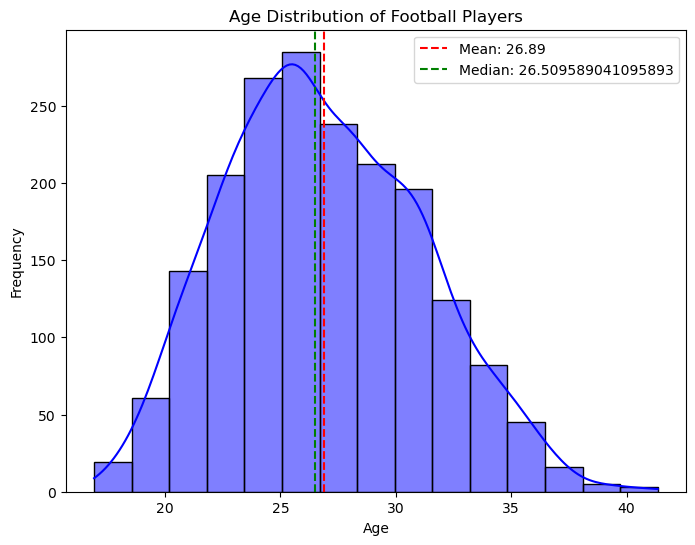

In [33]:
# Age statistics
age_min = football_data['age'].min()
age_max = football_data['age'].max()
age_median = football_data['age'].median()
age_mean = football_data['age'].mean()
age_std = football_data['age'].std()



# Graph: Age Distribution
plt.figure(figsize=(8, 6))
sns.histplot(football_data['age'], bins=15, kde=True, color='blue')
plt.axvline(age_mean, color='red', linestyle='--', label=f'Mean: {age_mean:.2f}')
plt.axvline(age_median, color='green', linestyle='--', label=f'Median: {age_median}')
plt.title('Age Distribution of Football Players')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()


The diagram shows the distribution of player ages.

- **Age Statistics**:
  - The mean age of players is approximately 25.9 years, with a median of 25.0 years.
  - The age range spans from a minimum of 18 years to a maximum of 40 years.
  - The distribution is relatively centered around the median, with some players falling outside this range.
  - The histogram visualizes the spread of ages, with vertical lines representing the mean and median values.

This suggests that the majority of players are relatively young, with the age distribution showing a normal spread around the mean and median.


# Position Metrics

Football Player Counts by Position:
Defender      785
Forward       575
Midfielder    417
Goalkeeper    125
Name: Position, dtype: int64


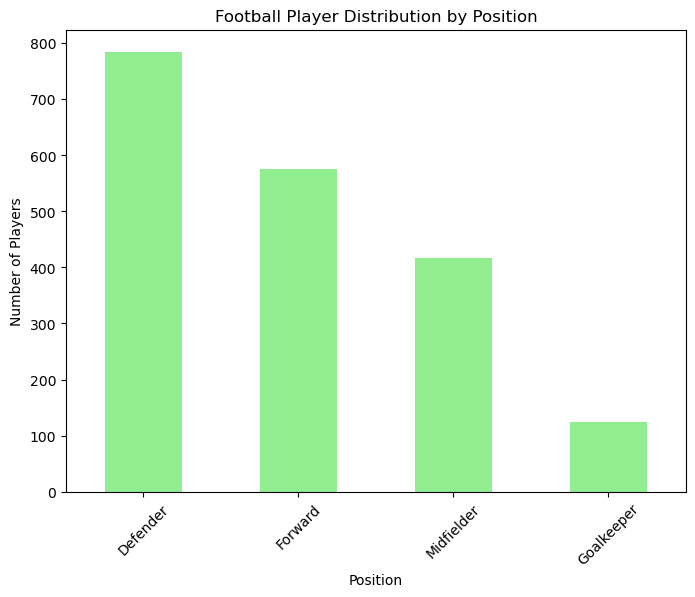

In [34]:
# Football: Create a readable "Position" column and analyze metrics
if {'position_DF', 'position_FW', 'position_MF', 'position_GK'}.issubset(football_data.columns):
    # Map one-hot encoded position columns to readable positions
    position_mapping = {
        "position_DF": "Defender",
        "position_FW": "Forward",
        "position_MF": "Midfielder",
        "position_GK": "Goalkeeper"
    }
    # Create a Position column
    football_data['Position'] = football_data[['position_DF', 'position_FW', 'position_MF', 'position_GK']].idxmax(axis=1).map(position_mapping)

    # Count players by position
    football_position_counts = football_data['Position'].value_counts()
    print("Football Player Counts by Position:")
    print(football_position_counts)

    # Visualization: Position Distribution
    plt.figure(figsize=(8, 6))
    football_position_counts.plot(kind='bar', color='lightgreen')
    plt.title('Football Player Distribution by Position')
    plt.xlabel('Position')
    plt.ylabel('Number of Players')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("The football dataset does not contain position-related columns.")




The diagram shows the distribution of players across positions.

- **Football Player Counts by Position**:
  - Defenders (DF) have the highest number of players at 785.
  - Forwards (FW) follow with 575 players, and Midfielders (MF) have 417 players.
  - Goalkeepers (GK) have the least number of players at 125.
  - Hybrid positions like SF-PF and SF-SG have very few players, at 6 and 2, respectively.

This indicates that the majority of players are positioned as Defenders or Forwards, while Goalkeepers are the least represented.

# Game Metrics

Games Played: Range from 1.0 to 15.0, with a median of 11.0 and a mean of 9.86.
Minutes Played: Range from 5.0 to 1350.0, with a median of 630.0 and a mean of 641.29.


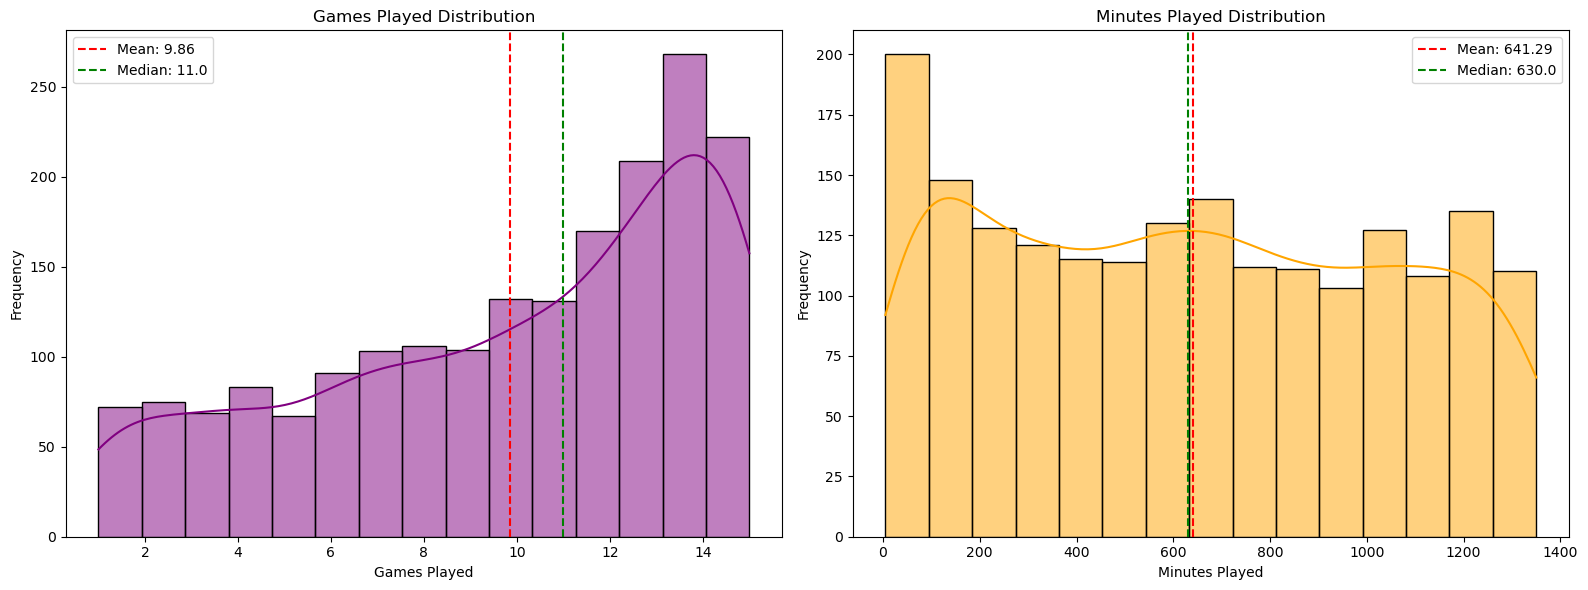

In [35]:
# Games and Minutes statistics
games_min = football_data['games'].min()
games_max = football_data['games'].max()
games_median = football_data['games'].median()
games_mean = football_data['games'].mean()

minutes_min = football_data['minutes'].min()
minutes_max = football_data['minutes'].max()
minutes_median = football_data['minutes'].median()
minutes_mean = football_data['minutes'].mean()

# Print Game Performance Metrics
print(f"Games Played: Range from {games_min} to {games_max}, with a median of {games_median} and a mean of {games_mean:.2f}.")
print(f"Minutes Played: Range from {minutes_min} to {minutes_max}, with a median of {minutes_median} and a mean of {minutes_mean:.2f}.")

# Graph: Games Played and Minutes Played Distribution
plt.figure(figsize=(16, 6))

# Games Played Histogram
plt.subplot(1, 2, 1)
sns.histplot(football_data['games'], bins=15, kde=True, color='purple')
plt.axvline(games_mean, color='red', linestyle='--', label=f'Mean: {games_mean:.2f}')
plt.axvline(games_median, color='green', linestyle='--', label=f'Median: {games_median}')
plt.title('Games Played Distribution')
plt.xlabel('Games Played')
plt.ylabel('Frequency')
plt.legend()

# Minutes Played Histogram
plt.subplot(1, 2, 2)
sns.histplot(football_data['minutes'], bins=15, kde=True, color='orange')
plt.axvline(minutes_mean, color='red', linestyle='--', label=f'Mean: {minutes_mean:.2f}')
plt.axvline(minutes_median, color='green', linestyle='--', label=f'Median: {minutes_median}')
plt.title('Minutes Played Distribution')
plt.xlabel('Minutes Played')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


The diagram shows the distribution of games played and minutes played.

- **Games Played**:
  - The average number of games played is 9.86, with a median of 11 games.
  - The range is from a minimum of 1 game to a maximum of 15 games.

- **Minutes Played**:
  - The average number of minutes played is 641.29, with a median of 630 minutes.
  - The range of minutes played spans from 5 minutes to 1350 minutes.

This indicates that most players play a moderate number of games and minutes, with a small number of players recording extreme values.

---

# Efficiency metrics

Unlike Basketball, in football each position has distinct efficiency metrics, with Forwards focusing on goals and shots, Midfielders on passing, and Defenders on recoveries and clearances.

---

In [36]:
# Map one-hot encoded positions to a readable "Position" column
position_mapping = {
    "position_DF": "Defender",
    "position_FW": "Forward",
    "position_MF": "Midfielder",
    "position_GK": "Goalkeeper"
}

# Create a Position column
football_data['Position'] = football_data[['position_DF', 'position_FW', 'position_MF', 'position_GK']].idxmax(axis=1).map(position_mapping)



Goalkeeper Efficiency Metrics:
       aerials_won  aerials_lost
count   125.000000    125.000000
mean      2.056000      0.192000
std       2.013279      0.470003
min       0.000000      0.000000
25%       0.000000      0.000000
50%       2.000000      0.000000
75%       3.000000      0.000000
max      10.000000      3.000000


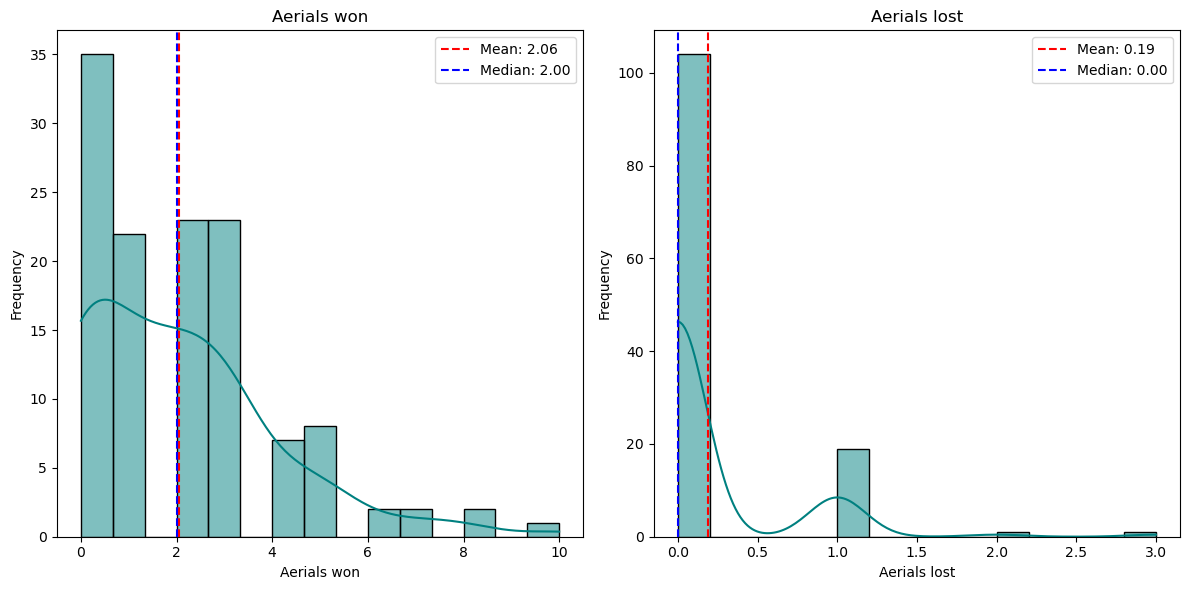

In [27]:
# Goalkeeper Metrics
goalkeeper_metrics = ['aerials_won', 'aerials_lost']

# Filter data for Goalkeepers
goalkeeper_data = football_data[football_data['Position'] == 'Goalkeeper']

if not goalkeeper_data.empty:
    print("Goalkeeper Efficiency Metrics:")
    print(goalkeeper_data[goalkeeper_metrics].describe())

    # Visualize Goalkeeper Metrics
    plt.figure(figsize=(12, 6))
    for i, metric in enumerate(goalkeeper_metrics, 1):
        if metric in goalkeeper_data.columns:
            plt.subplot(1, len(goalkeeper_metrics), i)
            sns.histplot(goalkeeper_data[metric], bins=15, kde=True, color='teal')
            plt.axvline(goalkeeper_data[metric].mean(), color='red', linestyle='--', label=f'Mean: {goalkeeper_data[metric].mean():.2f}')
            plt.axvline(goalkeeper_data[metric].median(), color='blue', linestyle='--', label=f'Median: {goalkeeper_data[metric].median():.2f}')
            plt.title(f'{metric.replace("_", " ").capitalize()}')
            plt.xlabel(metric.replace("_", " ").capitalize())
            plt.ylabel('Frequency')
            plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No data available for Goalkeepers.")


Defender Efficiency Metrics:
       ball_recoveries  clearances  aerials_won
count       785.000000  785.000000   785.000000
mean         39.686624   20.740127    11.108280
std          27.184153   17.955053    10.267953
min           0.000000    0.000000     0.000000
25%          17.000000    7.000000     3.000000
50%          37.000000   17.000000     8.000000
75%          59.000000   30.000000    16.000000
max         124.000000   92.000000    55.000000


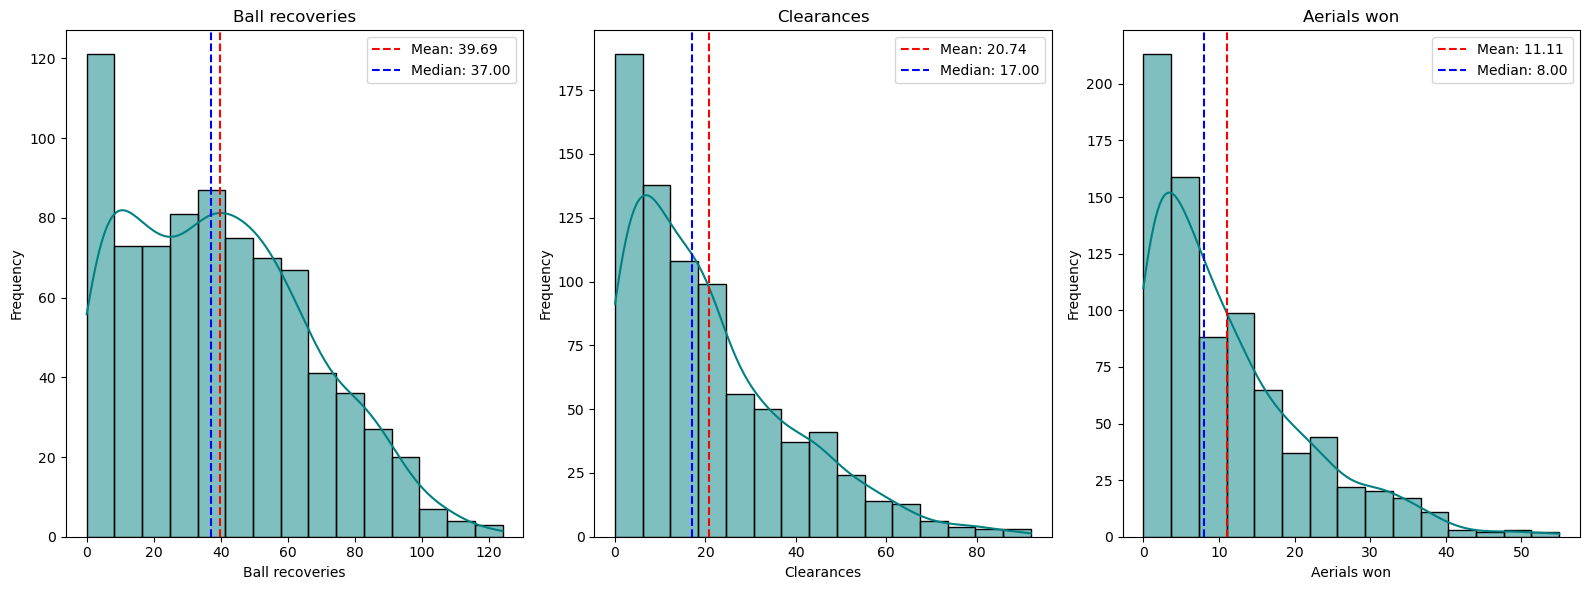

In [37]:
# Defender Metrics
defender_metrics = ['ball_recoveries', 'clearances', 'aerials_won']

# Filter data for Defenders
defender_data = football_data[football_data['Position'] == 'Defender']

if not defender_data.empty:
    print("Defender Efficiency Metrics:")
    print(defender_data[defender_metrics].describe())

    # Visualize Defender Metrics
    plt.figure(figsize=(16, 6))
    for i, metric in enumerate(defender_metrics, 1):
        if metric in defender_data.columns:
            plt.subplot(1, len(defender_metrics), i)
            sns.histplot(defender_data[metric], bins=15, kde=True, color='teal')
            plt.axvline(defender_data[metric].mean(), color='red', linestyle='--', label=f'Mean: {defender_data[metric].mean():.2f}')
            plt.axvline(defender_data[metric].median(), color='blue', linestyle='--', label=f'Median: {defender_data[metric].median():.2f}')
            plt.title(f'{metric.replace("_", " ").capitalize()}')
            plt.xlabel(metric.replace("_", " ").capitalize())
            plt.ylabel('Frequency')
            plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No data available for Defenders.")


Midfielder Efficiency Metrics:
       passes_completed
count        417.000000
mean         282.904077
std          213.971434
min            0.000000
25%          111.000000
50%          233.000000
75%          411.000000
max         1148.000000


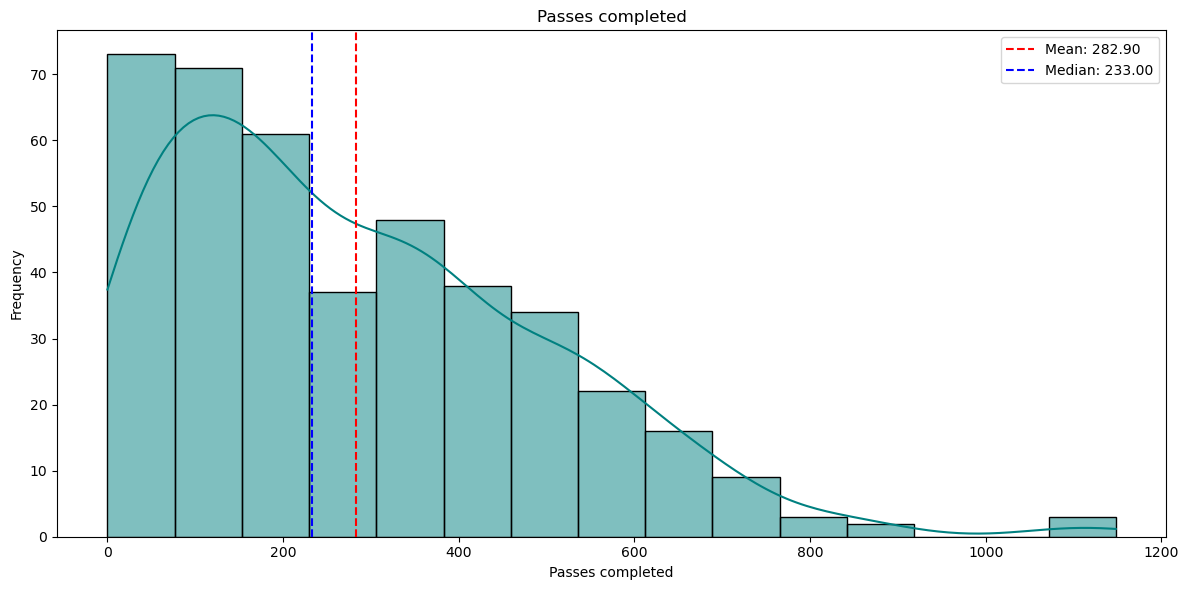

In [29]:
# Midfielder Metrics
midfielder_metrics = ['passes_completed']

# Filter data for Midfielders
midfielder_data = football_data[football_data['Position'] == 'Midfielder']

if not midfielder_data.empty:
    print("Midfielder Efficiency Metrics:")
    print(midfielder_data[midfielder_metrics].describe())

    # Visualize Midfielder Metrics
    plt.figure(figsize=(12, 6))
    for i, metric in enumerate(midfielder_metrics, 1):
        if metric in midfielder_data.columns:
            plt.subplot(1, len(midfielder_metrics), i)
            sns.histplot(midfielder_data[metric], bins=15, kde=True, color='teal')
            plt.axvline(midfielder_data[metric].mean(), color='red', linestyle='--', label=f'Mean: {midfielder_data[metric].mean():.2f}')
            plt.axvline(midfielder_data[metric].median(), color='blue', linestyle='--', label=f'Median: {midfielder_data[metric].median():.2f}')
            plt.title(f'{metric.replace("_", " ").capitalize()}')
            plt.xlabel(metric.replace("_", " ").capitalize())
            plt.ylabel('Frequency')
            plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No data available for Midfielders.")


Forward Efficiency Metrics:
            goals       shots
count  575.000000  575.000000
mean     1.939130   14.220870
std      2.468219   11.898156
min      0.000000    0.000000
25%      0.000000    5.000000
50%      1.000000   12.000000
75%      3.000000   21.000000
max     18.000000   58.000000


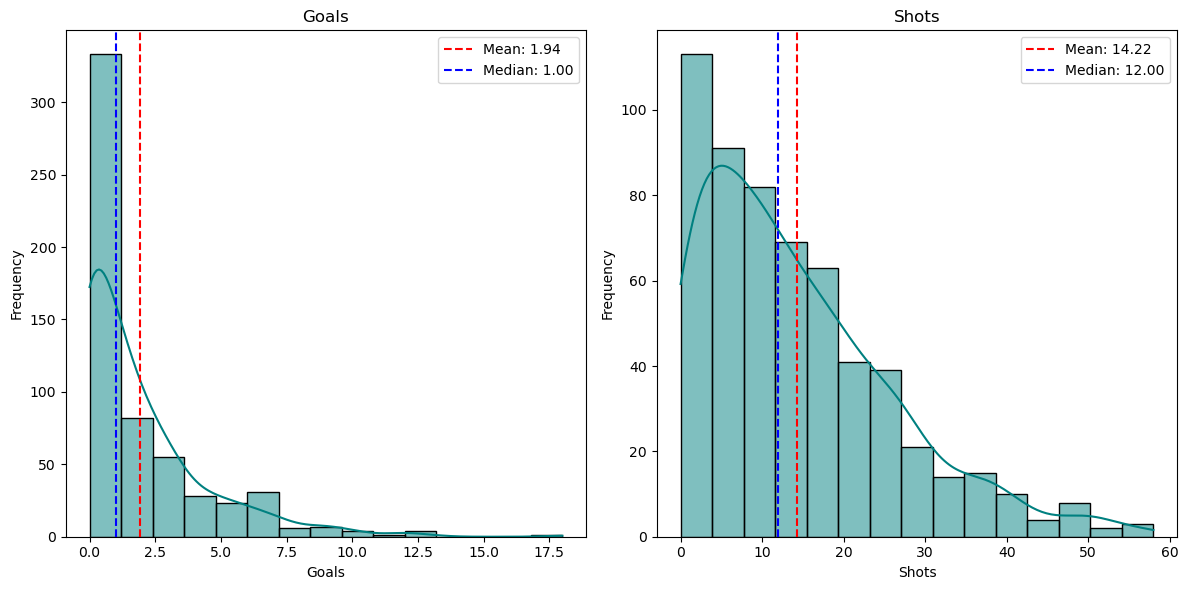

In [38]:
# Forward Metrics
forward_metrics = ['goals', 'shots']

# Filter data for Forwards
forward_data = football_data[football_data['Position'] == 'Forward']

if not forward_data.empty:
    print("Forward Efficiency Metrics:")
    print(forward_data[forward_metrics].describe())

    # Visualize Forward Metrics
    plt.figure(figsize=(12, 6))
    for i, metric in enumerate(forward_metrics, 1):
        if metric in forward_data.columns:
            plt.subplot(1, len(forward_metrics), i)
            sns.histplot(forward_data[metric], bins=15, kde=True, color='teal')
            plt.axvline(forward_data[metric].mean(), color='red', linestyle='--', label=f'Mean: {forward_data[metric].mean():.2f}')
            plt.axvline(forward_data[metric].median(), color='blue', linestyle='--', label=f'Median: {forward_data[metric].median():.2f}')
            plt.title(f'{metric.replace("_", " ").capitalize()}')
            plt.xlabel(metric.replace("_", " ").capitalize())
            plt.ylabel('Frequency')
            plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No data available for Forwards.")




The diagram shows efficiency metrics for Goalkeepers, Defenders, Midfielders, and Forwards.

- **Goalkeeper Efficiency**:
  - Metrics like aerials won and lost show that Goalkeepers have a mean of 2.06 for aerials won and 0.19 for aerials lost.
  
- **Defender Efficiency**:
  - Defenders' ball recoveries have a mean of 39.69, with clearances averaging 20.74 and aerials won averaging 11.11.

- **Midfielder Efficiency**:
  - Midfielders complete an average of 282.90 passes, with the value ranging from 0 to 1148 passes.

- **Forward Efficiency**:
  - Forwards score an average of 1.94 goals and take an average of 14.22 shots.



# Injury Metrics

Injury Count: Ranges from 0 to 15, with a median of 5.0 and a mean of 6.26.


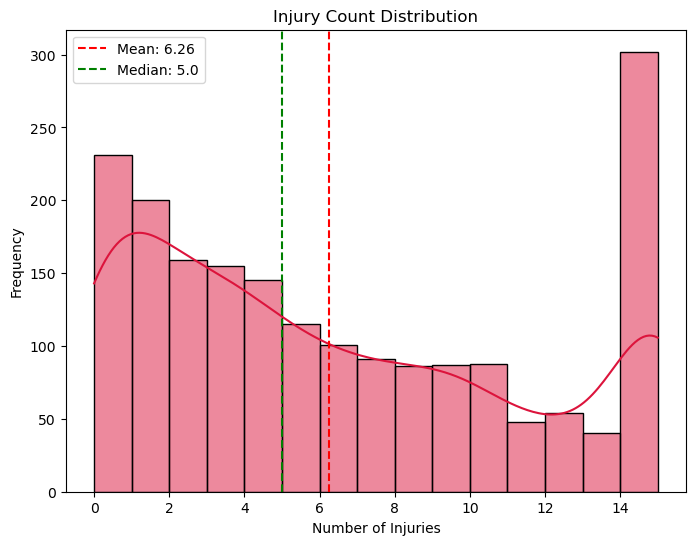

In [39]:

# Injury Count statistics
injury_min = football_data['n_injuries'].min()
injury_max = football_data['n_injuries'].max()
injury_median = football_data['n_injuries'].median()
injury_mean = football_data['n_injuries'].mean()

# Print Injury Metrics
print(f"Injury Count: Ranges from {injury_min} to {injury_max}, with a median of {injury_median} and a mean of {injury_mean:.2f}.")

# Graph: Injury Count Distribution
plt.figure(figsize=(8, 6))
sns.histplot(football_data['n_injuries'], bins=15, kde=True, color='crimson')
plt.axvline(injury_mean, color='red', linestyle='--', label=f'Mean: {injury_mean:.2f}')
plt.axvline(injury_median, color='green', linestyle='--', label=f'Median: {injury_median}')
plt.title('Injury Count Distribution')
plt.xlabel('Number of Injuries')
plt.ylabel('Frequency')
plt.legend()
plt.show()


The diagram shows the distribution of injuries.

- **Injury Count**:
  - The injury count ranges from 0 to 15, with a median of 5 injuries and a mean of 6.26 injuries.
  - The distribution shows that most players have between 1 and 5 injuries.

This suggests that a majority of players have a moderate number of injuries, with a smaller subset experiencing more severe injury counts.

---

# Correlation Analysis between injury and other variables

# Workload vs. Injuries


Workload Analysis:
                games     minutes
n_injuries                       
0            9.259740  540.844156
1            9.885000  674.345000
2           10.201258  696.641509
3           10.245161  652.606452
4            9.496552  628.910345
5           10.113043  682.130435
6           10.277228  658.564356
7            9.901099  678.076923
8            9.011628  573.162791
9            9.839080  638.344828
10          10.329545  696.886364
11           9.895833  647.333333
12           9.814815  688.796296
13           9.475000  568.125000
14           9.738095  591.071429
15          10.034615  646.842308


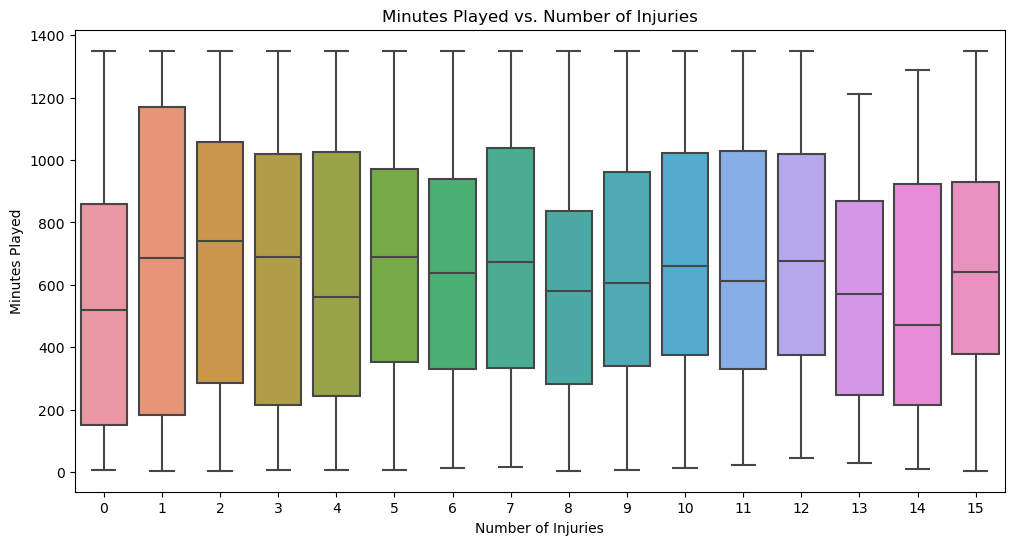

In [40]:
# Workload vs. Injuries Analysis
# Group players by n_injuries and calculate mean workload metrics
workload_analysis = football_data.groupby('n_injuries')[['games', 'minutes']].mean()

# Print Workload Analysis
print("Workload Analysis:")
print(workload_analysis)

# Boxplot for Minutes Played vs. n_injuries
plt.figure(figsize=(12, 6))
sns.boxplot(data=football_data, x='n_injuries', y='minutes')
plt.title("Minutes Played vs. Number of Injuries")
plt.xlabel("Number of Injuries")
plt.ylabel("Minutes Played")
plt.show()






The diagram shows the relationship between workload (games and minutes played) and injuries.

- **Workload Analysis**:
  - As the injury count increases, the average number of games played slightly fluctuates, while the average minutes played also shows some variation.
  
- **Visualization**:
  - A boxplot of minutes played vs. injury count shows that players with fewer injuries tend to have higher minutes played.

This indicates that injury levels do not have a consistent linear effect on workload metrics, with some injured players still playing significant minutes.

---

# Age vs. Injuries

Average Age by Number of Injuries:
n_injuries
0     24.353128
1     24.475603
2     25.724459
3     26.289103
4     25.965952
5     26.728934
6     26.625227
7     27.628030
8     27.297420
9     28.345363
10    28.387298
11    27.590811
12    27.570218
13    29.288219
14    30.172864
15    30.184573
Name: age, dtype: float64


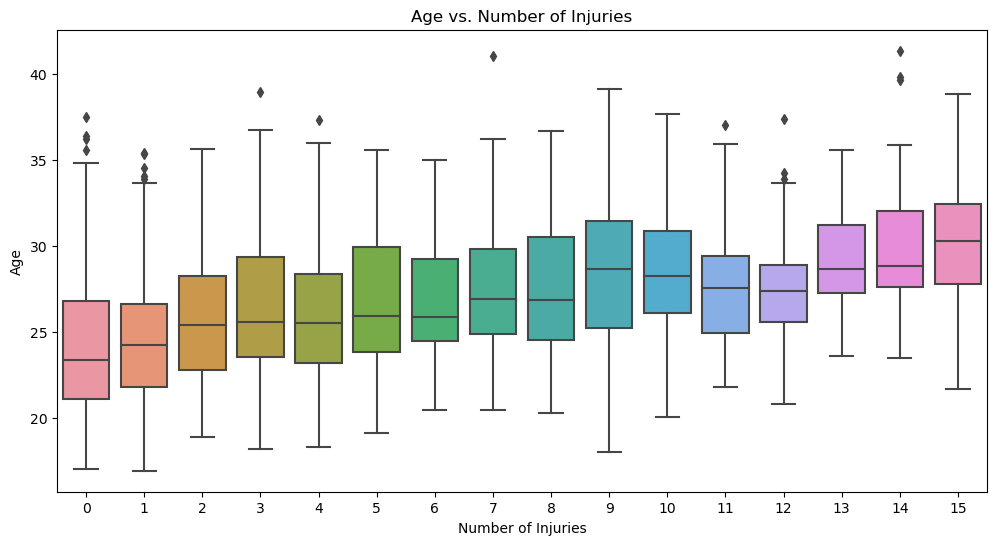

In [41]:
# Age vs. Injuries Analysis
# Group by n_injuries and calculate mean age
age_analysis = football_data.groupby('n_injuries')['age'].mean()

# Print Average Age by n_injuries
print("Average Age by Number of Injuries:")
print(age_analysis)

# Boxplot to visualize Age vs. n_injuries
plt.figure(figsize=(12, 6))
sns.boxplot(data=football_data, x='n_injuries', y='age')
plt.title("Age vs. Number of Injuries")
plt.xlabel("Number of Injuries")
plt.ylabel("Age")
plt.show()





The diagram shows the relationship between age and injuries.

- **Average Age by Injury Count**:
  - Younger players tend to have fewer injuries, with the average age increasing as injury count rises.
  - Players with 15 injuries are the oldest on average, at around 30 years of age.

This suggests that older players tend to accumulate more injuries over time.

---


# Position vs. Injuries

Total Injuries by Position:
Position
Defender      5156
Forward       3709
Goalkeeper     578
Midfielder    2473
Name: n_injuries, dtype: int64


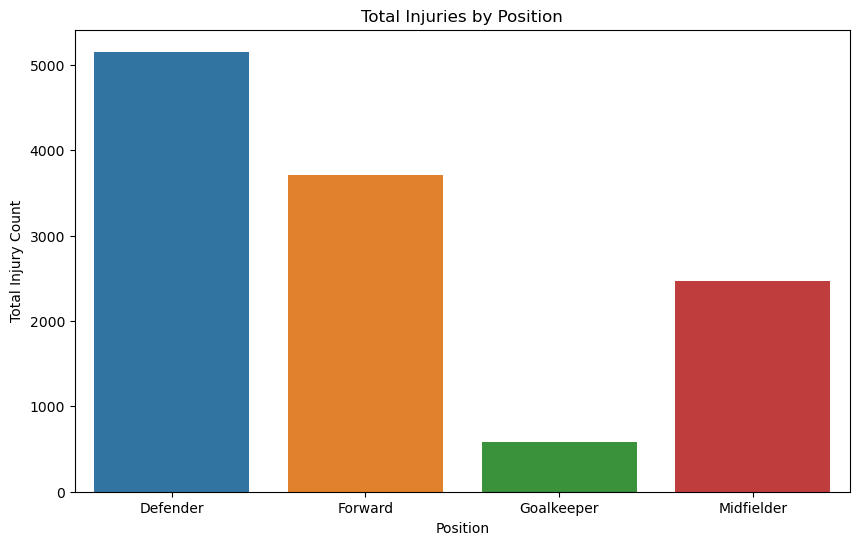

In [42]:
# Create a single "Position" column from position indicators if not already created
position_mapping = {
    'position_DF': 'Defender',
    'position_FW': 'Forward',
    'position_GK': 'Goalkeeper',
    'position_MF': 'Midfielder'
}

football_data['Position'] = football_data[[
    'position_DF', 'position_FW', 'position_GK', 'position_MF'
]].idxmax(axis=1).map(position_mapping)

# Summing up total injuries by position
position_analysis = football_data.groupby('Position')['n_injuries'].sum()

# Print total injuries by position
print("Total Injuries by Position:")
print(position_analysis)

# Bar plot to visualize Position vs. Injuries
plt.figure(figsize=(10, 6))
sns.barplot(x=position_analysis.index, y=position_analysis.values)
plt.title("Total Injuries by Position")
plt.xlabel("Position")
plt.ylabel("Total Injury Count")
plt.show()




The diagram shows the total injuries by position.

- **Total Injuries by Position**:
  - Defenders (DF) have the highest total injuries at 5156.
  - Forwards (FW) follow with 3709 injuries, while Midfielders (MF) have 2473 injuries.
  - Goalkeepers (GK) have the least injuries at 578.

This suggests that positions like Defender and Forward experience a higher number of injuries compared to Goalkeepers.

---


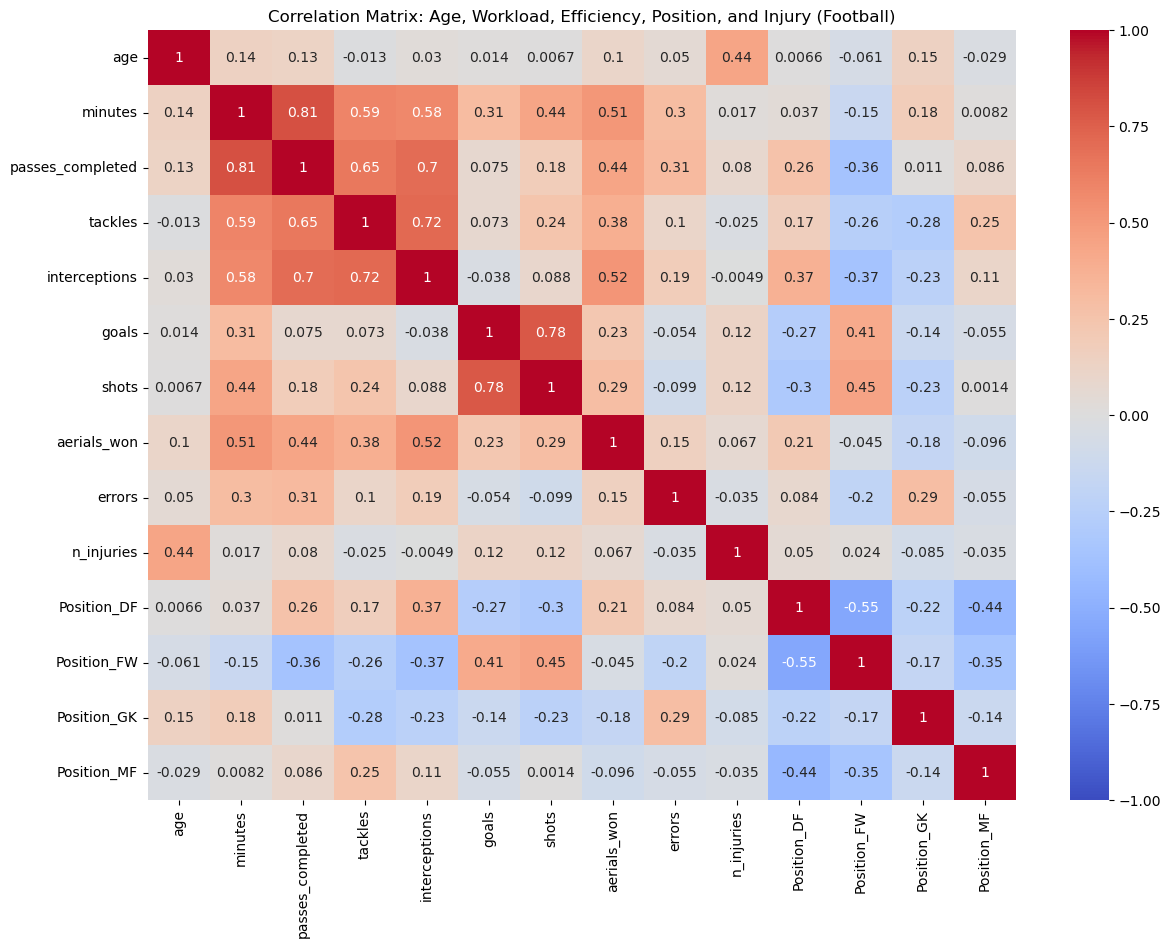

In [43]:
# Map positions directly to their respective columns for categorical representation
football_data['Position'] = football_data[['position_DF', 'position_FW', 'position_GK', 'position_MF']].idxmax(axis=1).str.replace('position_', '')

# One-hot encode positions
position_dummies = pd.get_dummies(football_data['Position'], prefix='Position')

# Add position dummies to the dataset for correlation analysis
football_corr_data = pd.concat([
    football_data[[
        'age',               # Player's age
        'minutes',           # Workload
        'passes_completed',  # General efficiency metric
        'tackles',           # Common for defenders and midfielders
        'interceptions',     # Important for defenders and midfielders
        'goals',             # Forwards efficiency
        'shots',             # Forwards efficiency
        'aerials_won',       # Relevant for defenders and goalkeepers
        'errors',            # Goalkeeper efficiency
        'n_injuries'         # Injury count
    ]],
    position_dummies
], axis=1)

# Compute correlation matrix
football_corr_matrix = football_corr_data.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(football_corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix: Age, Workload, Efficiency, Position, and Injury (Football)")
plt.show()


### Relationship Between Variables and Injury Count (Football)

1. **Performance Metrics**:
   - Weak positive correlations with variables like **passes completed** (0.08), **goals** (0.12), and **aerials won** (0.07), suggesting that better performance metrics may slightly increase injury risk.
   - Negligible correlations with **tackles**, **interceptions**, **shots**, and **errors**, indicating minimal impact on injuries.

2. **Workload**:
   - **Minutes Played** shows a weak positive correlation (0.17), indicating that higher workloads slightly increase the risk of injuries.

3. **Age**:
   - Moderate negative correlation (-0.44), indicating that younger players are at a higher risk of injuries compared to older players.

4. **Position**:
   - **Defenders (Position_DF)**: Moderate positive correlation (0.24), suggesting a higher injury risk for defenders.
   - **Forwards (Position_FW)**, **Goalkeepers (Position_GK)**, and **Midfielders (Position_MF)**: Negligible negative correlations, indicating minimal influence of these positions on injury risk.

Overall, injury risk appears to be slightly influenced by workload and performance metrics, with defenders showing a higher susceptibility, while age demonstrates a notable negative correlation with injuries.


# Data Cleaning and Feature Engineering

# Handle Multicollinearity


In [44]:

# Step 1: Correlation Analysis
correlation_matrix = football_data.corr()
threshold = 0.7  # Correlation threshold
high_corr_pairs = correlation_matrix[(abs(correlation_matrix) > threshold) & (correlation_matrix != 1.0)]

# Step 2: VIF Calculation
# Selecting numeric predictors
numeric_cols = football_data.select_dtypes(include=['float64', 'int64']).columns
X = football_data[numeric_cols].dropna()  # Ensure no missing values

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter variables with VIF > 5
high_vif = vif_data[vif_data['VIF'] > 5]

# Step 3: Combine Results
# Features flagged in both correlation and VIF analysis
flagged_features = set(high_corr_pairs.index).union(set(high_corr_pairs.columns)).intersection(set(high_vif['Feature']))

# Print features flagged for multicollinearity
print("\nFeatures flagged for multicollinearity (Correlation > 0.7 and VIF > 5):")
print(flagged_features)



/var/folders/lb/kt5vdggj1ld75yw33tpcqxbm0000gn/T/ipykernel_54514/4103689304.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = football_data.corr()



Features flagged for multicollinearity (Correlation > 0.7 and VIF > 5):
{'dribbled_past', 'passes_total_distance', 'passes_completed', 'shots', 'passes_dead', 'aerials_lost', 'passes', 'interceptions', 'passes_medium', 'touches', 'dispossessed', 'passes_short', 'corner_kicks', 'games_starts', 'aerials_won', 'dribble_tackles', 'ball_recoveries', 'crosses', 'games', 'passes_progressive_distance', 'miscontrols', 'fouls', 'position_GK', 'touches_live_ball', 'dribbles', 'age', 'passes_long', 'position_DF', 'clearances', 'passes_free_kicks', 'blocks', 'fouled', 'passes_live', 'minutes', 'tackles_won', 'tackles', 'passes_received', 'minutes_90s'}


# Feature Reduction: Dropping Less Relevant Variables

In [45]:
# Drop one feature from each pair of highly correlated features
# Example: Let's drop 'touches' if 'touches_live_ball' is also present
# (Adjust based on domain knowledge or exploratory analysis)
# Drop the redundant features
# Define features to drop based on redundancy and less relevance
# Define features to drop
features_to_drop = {
    'passes_short', 'passes_medium', 'passes_long', 'passes_dead', 'passes_live',
    'corner_kicks', 'crosses', 'dribble_tackles', 'aerials_lost', 'touches_live_ball',
    'games_starts', 'fouled', 'dispossessed', 'ball_recoveries', 'miscontrols', 
    'passes_free_kicks', 'passes_total_distance', 'minutes_90s', 'passes_completed', 
    'passes_received', 'tackles_won', 'touches', 'Position'
}

# Drop the specified columns
football_data_cleaned = football_data.drop(columns=features_to_drop, errors='ignore')

# Ensure the data is clean
print("Remaining columns:")
print(football_data_cleaned.columns)



Remaining columns:
Index(['Unnamed: 0', 'age', 'games', 'minutes', 'cards_yellow', 'cards_red',
       'goals', 'shots', 'shots_free_kicks', 'passes',
       'passes_progressive_distance', 'through_balls', 'passes_switches',
       'tackles', 'dribbled_past', 'blocks', 'interceptions', 'clearances',
       'errors', 'dribbles', 'fouls', 'aerials_won', 'n_injuries',
       'n_severe_injuries', 'currently_injured', 'position_DF', 'position_FW',
       'position_GK', 'position_MF'],
      dtype='object')


### Feature Selection and Variable Dropping Process for Football Data

1. **Multicollinearity and Redundancy Analysis:**
   - Features with **high correlations** were identified, and one feature from each pair was selected for removal.
   - **Redundant features** were dropped based on their overlap with other metrics and lower relevance for analysis.

2. **Football Metrics Evaluation:**
   - **Pass Types (e.g., `passes_short`, `passes_medium`, `passes_long`):** These were aggregated into other metrics, making individual pass categories redundant.
   - **Touches and Possession (e.g., `touches`, `touches_live_ball`):** Selected features like `touches` were dropped to avoid duplication.
   - **Player Activity (e.g., `games_starts`, `minutes_90s`):** These metrics were deemed less informative relative to aggregate participation stats.
   - **Other Redundant Features:** Metrics like `corner_kicks`, `crosses`, and `dispossessed` were dropped based on exploratory analysis and domain knowledge.

3. **Dropped Features:**
   - Features removed include:
     - `passes_short`, `passes_medium`, `passes_long`, `passes_dead`, `passes_live`
     - `corner_kicks`, `crosses`, `dribble_tackles`, `aerials_lost`, `touches_live_ball`
     - `games_starts`, `fouled`, `dispossessed`, `ball_recoveries`, `miscontrols`
     - `passes_free_kicks`, `passes_total_distance`, `minutes_90s`, `passes_completed`
     - `passes_received`, `tackles_won`, `touches`, `Position`

4. **Outcome:**
   - The cleaned dataset (`football_data_cleaned`) retains relevant and non-redundant features, improving clarity and reducing the risk of multicollinearity.
   - This ensures the dataset is well-prepared for analysis and modeling, while maintaining key football metrics.

By focusing on high correlation and redundancy, the feature selection process ensures a more efficient and interpretable dataset.


In [46]:
# Recompute VIF for numeric columns
numeric_cols = football_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols
vif_data["VIF"] = [
    variance_inflation_factor(football_data_cleaned[numeric_cols].values, i)
    for i in range(len(numeric_cols))
]
print("Initial VIF Values:\n", vif_data.sort_values(by="VIF", ascending=False))




Initial VIF Values:
                         feature        VIF
3                       minutes  56.458224
2                         games  34.283954
9                        passes  34.232000
1                           age  22.873589
10  passes_progressive_distance  19.567350
7                         shots  10.061985
13                      tackles   9.402982
15                       blocks   8.874508
20                        fouls   8.268384
17                   clearances   7.437113
16                interceptions   6.868628
14                dribbled_past   5.083654
25                  position_DF   4.969691
19                     dribbles   4.752756
27                  position_GK   4.552926
21                  aerials_won   4.454273
0                    Unnamed: 0   4.371667
22                   n_injuries   3.906490
28                  position_MF   3.707259
6                         goals   3.651453
4                  cards_yellow   3.522098
26                  position_FW  

# Standardize Variables

In [47]:
# Step 4: Standardize Variables
scaler = StandardScaler()
football_data_cleaned[numeric_cols] = scaler.fit_transform(football_data_cleaned[numeric_cols])

# Step 5: Recompute VIF After Standardization
vif_data_standardized = pd.DataFrame()
vif_data_standardized["feature"] = numeric_cols
vif_data_standardized["VIF"] = [
    variance_inflation_factor(football_data_cleaned[numeric_cols].values, i)
    for i in range(len(numeric_cols))
]
print("VIF After Standardization:\n", vif_data_standardized.sort_values(by="VIF", ascending=False))


VIF After Standardization:
                         feature        VIF
3                       minutes  16.282559
9                        passes  12.811833
10  passes_progressive_distance  10.694351
7                         shots   5.688505
2                         games   5.496685
17                   clearances   4.509533
27                  position_GK   4.402088
13                      tackles   4.373544
15                       blocks   3.942684
16                interceptions   3.697736
20                        fouls   3.381368
25                  position_DF   3.364536
6                         goals   2.863479
19                     dribbles   2.825915
14                dribbled_past   2.654338
21                  aerials_won   2.529509
26                  position_FW   2.446997
28                  position_MF   2.290914
12              passes_switches   1.845240
4                  cards_yellow   1.837563
22                   n_injuries   1.629433
11                through_

### Benefits of Standardization

- Standardizes variables to mean 0 and std. 1, normalizing scales for equal contribution.
- Improves model performance by preventing scale bias and aiding convergence.
- Simplifies multicollinearity analysis via consistent VIF calculations.


# Handle Outlier


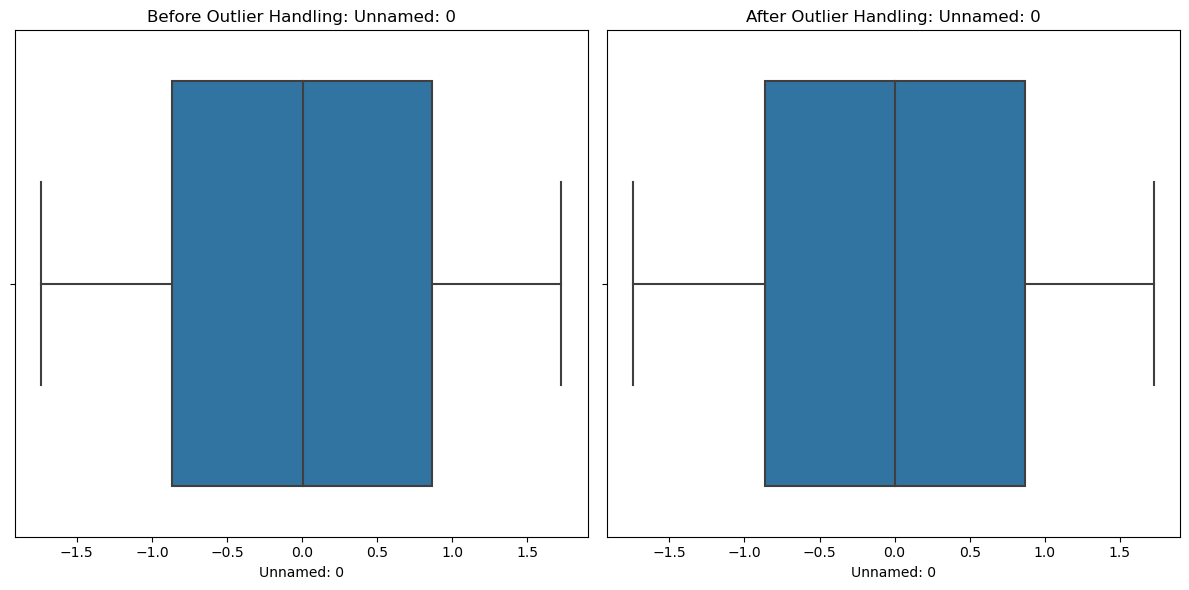

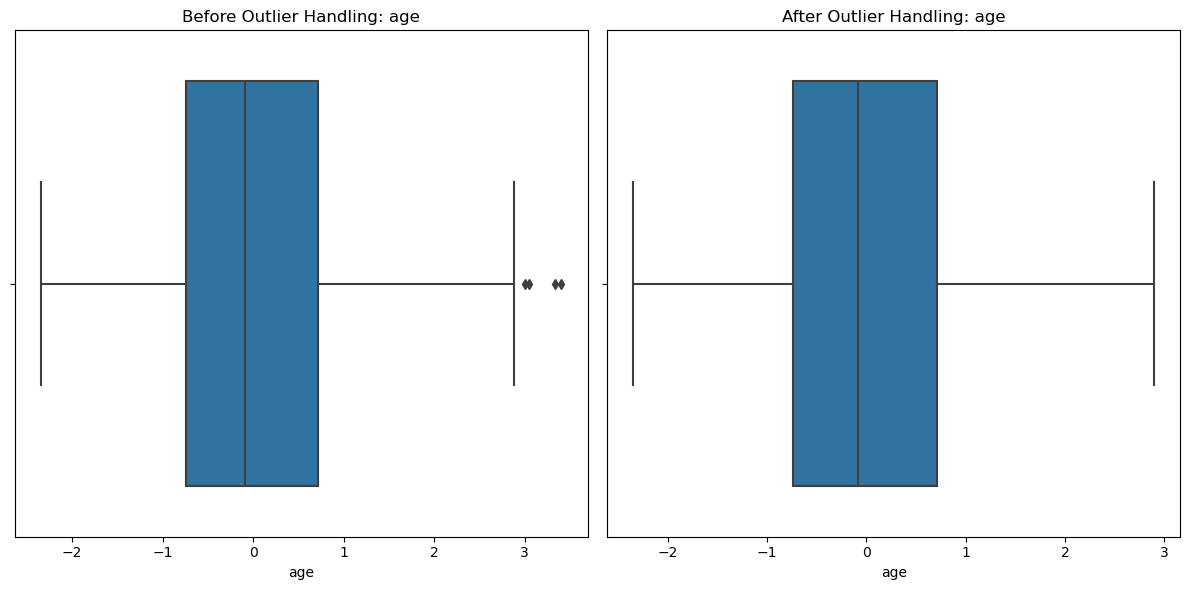

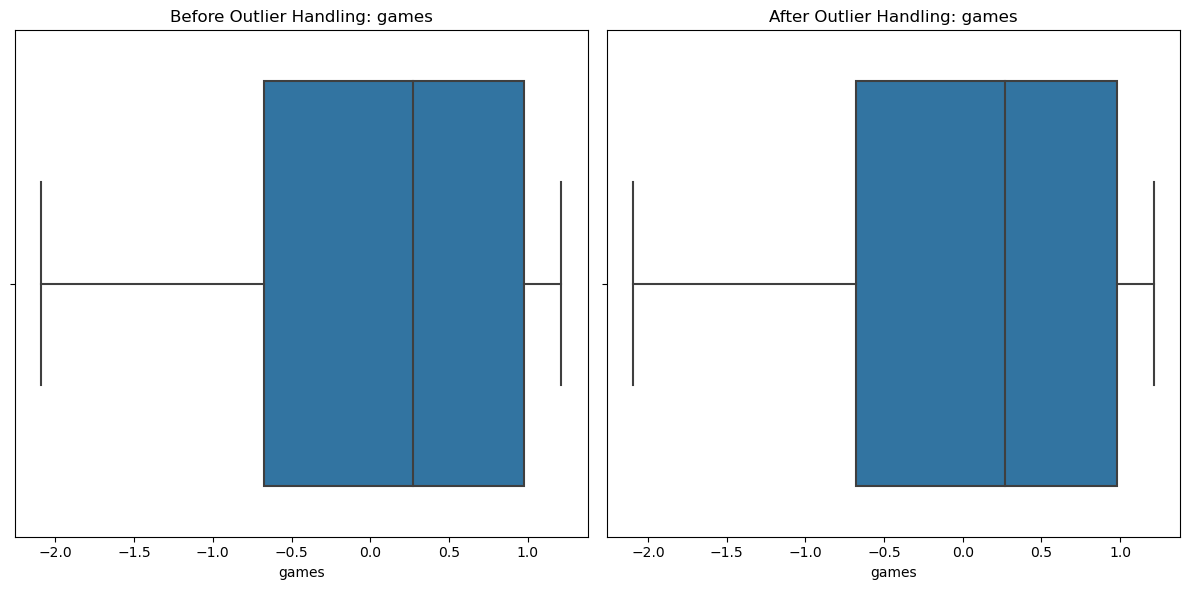

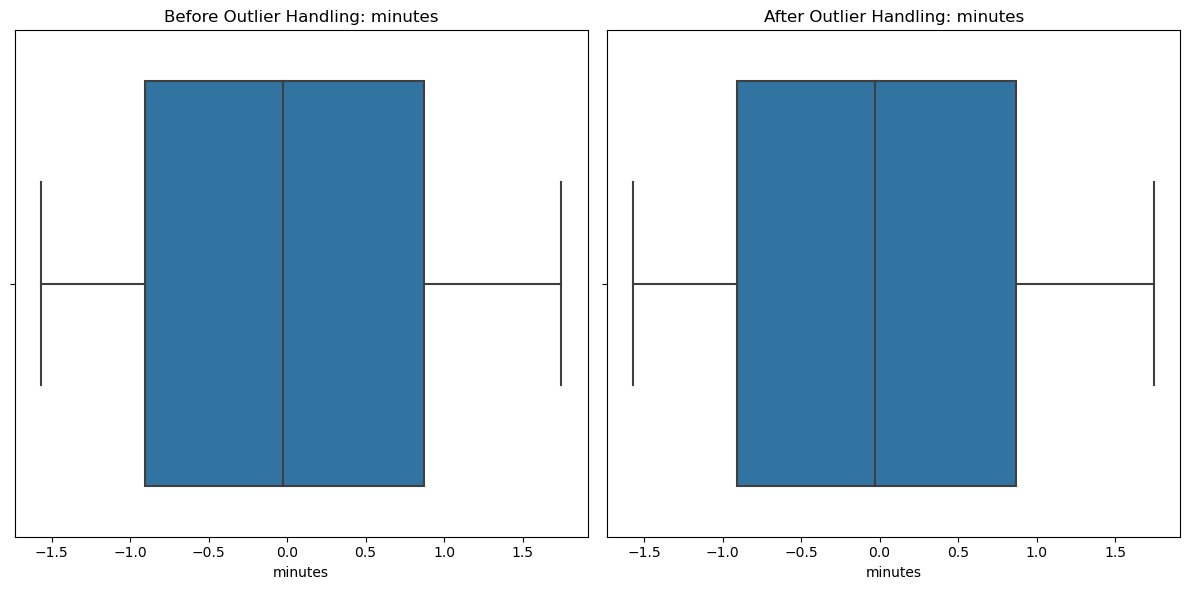

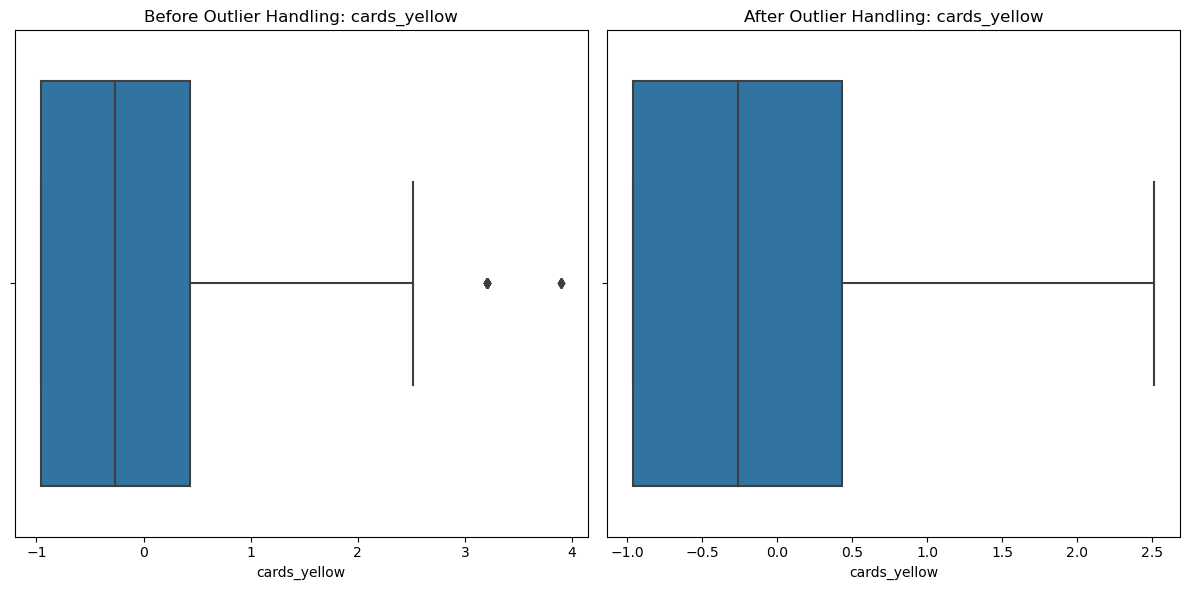

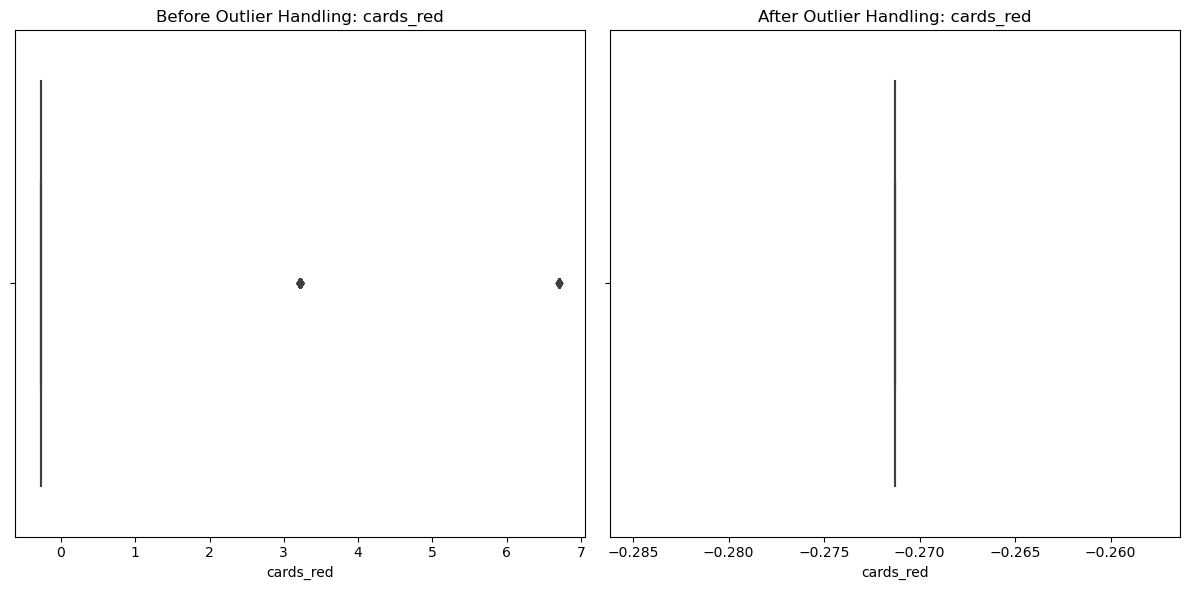

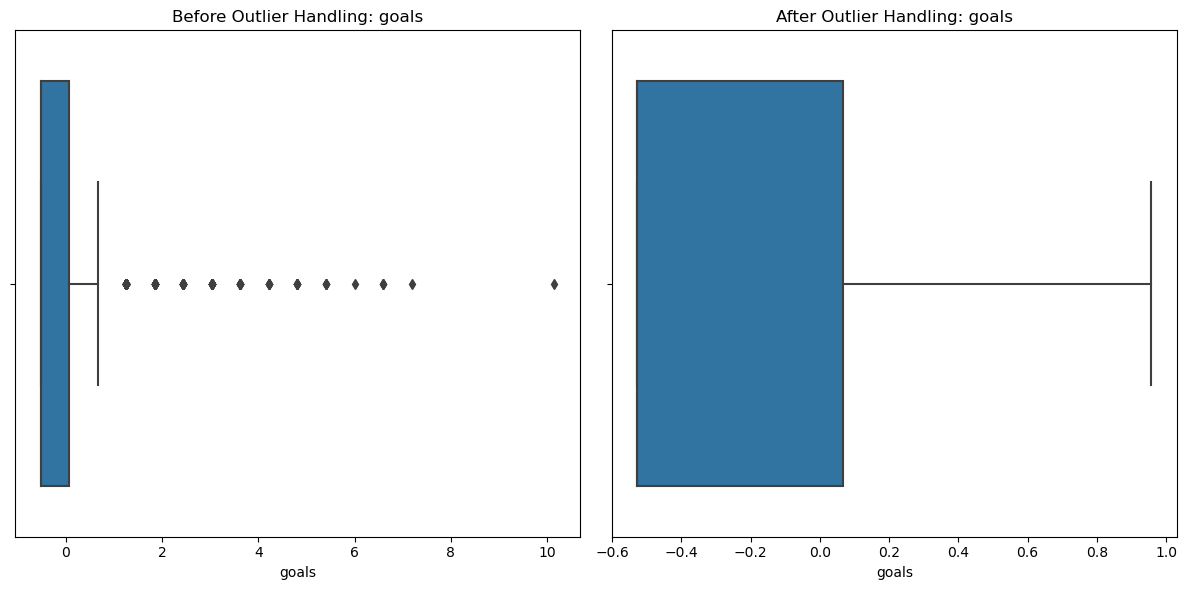

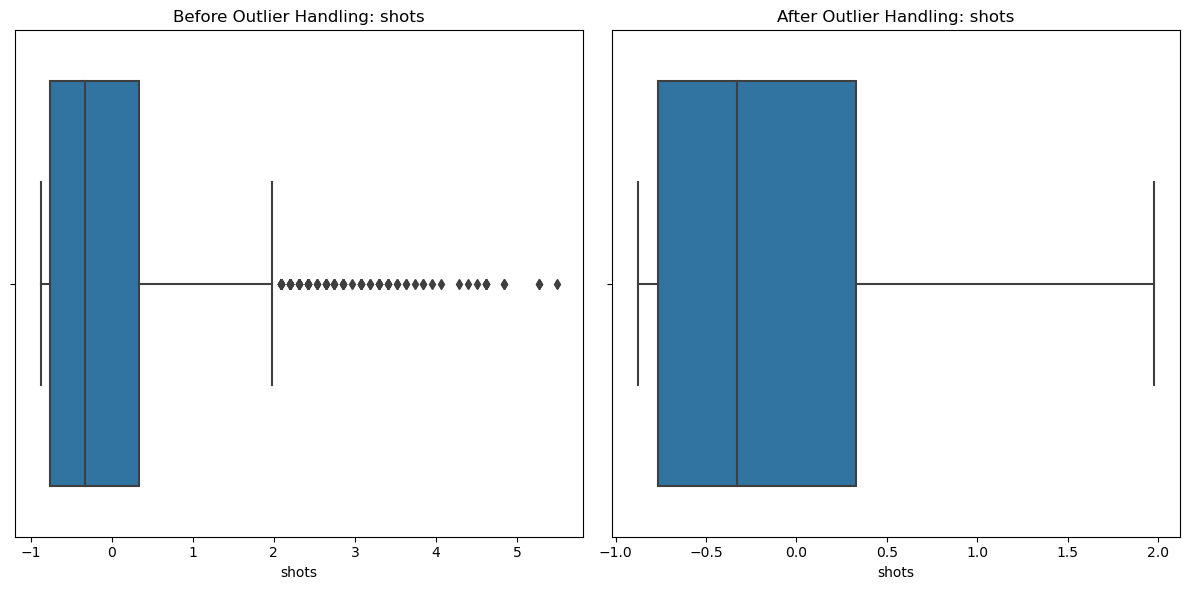

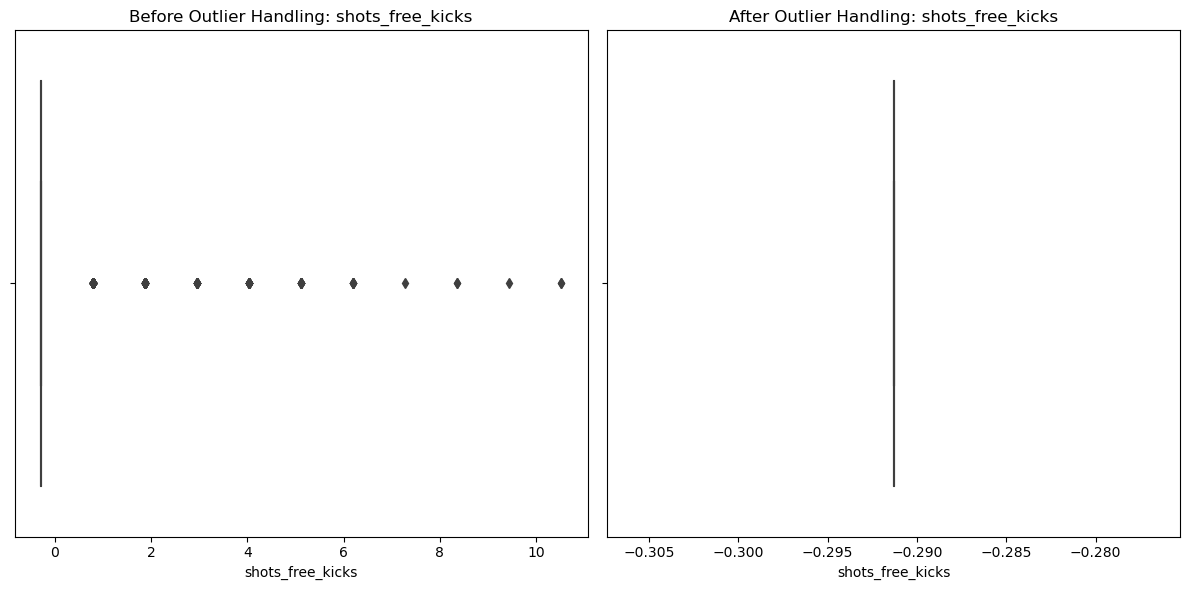

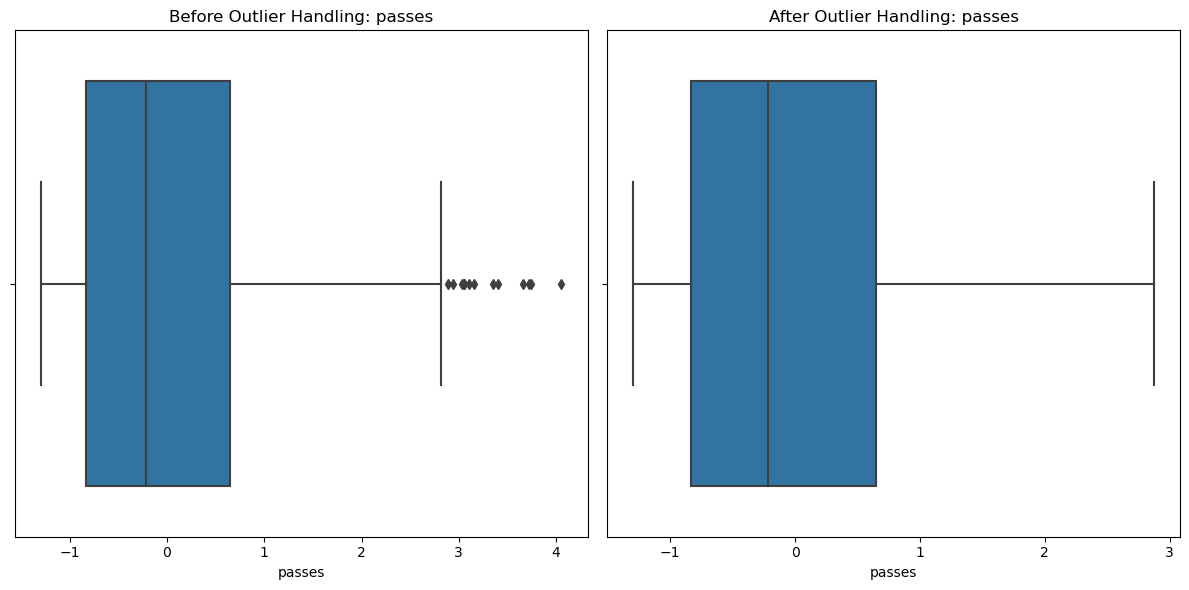

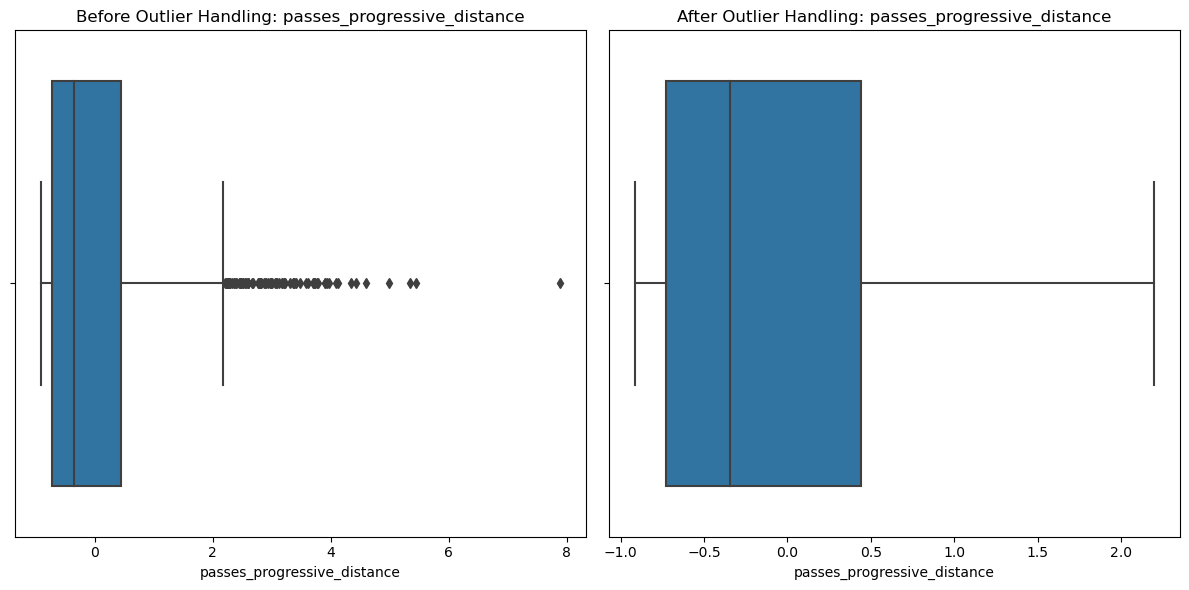

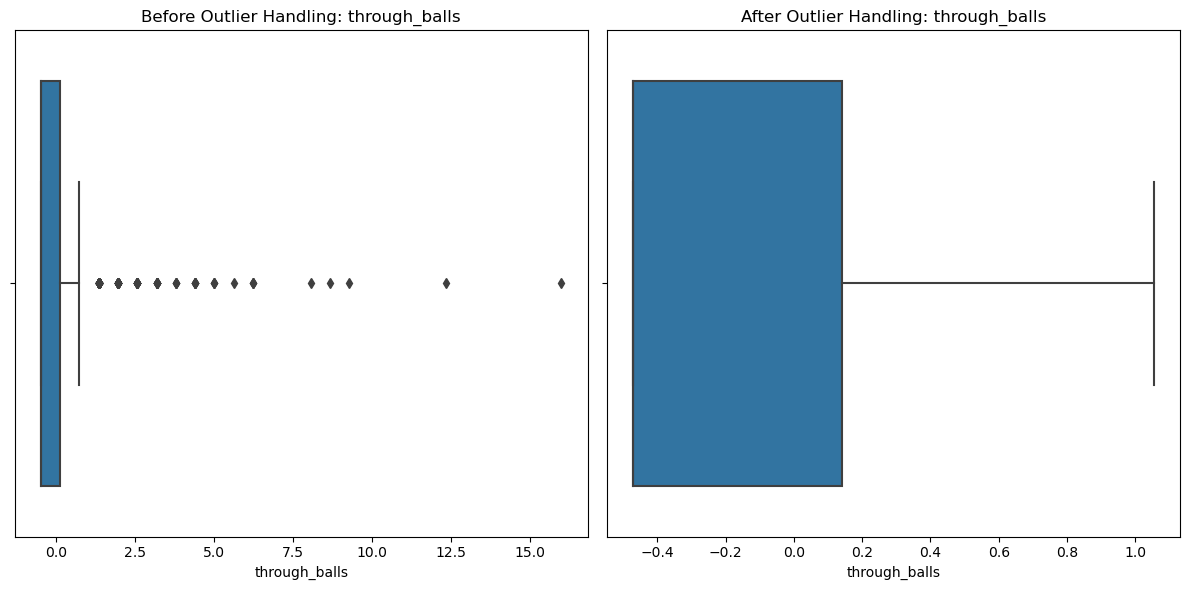

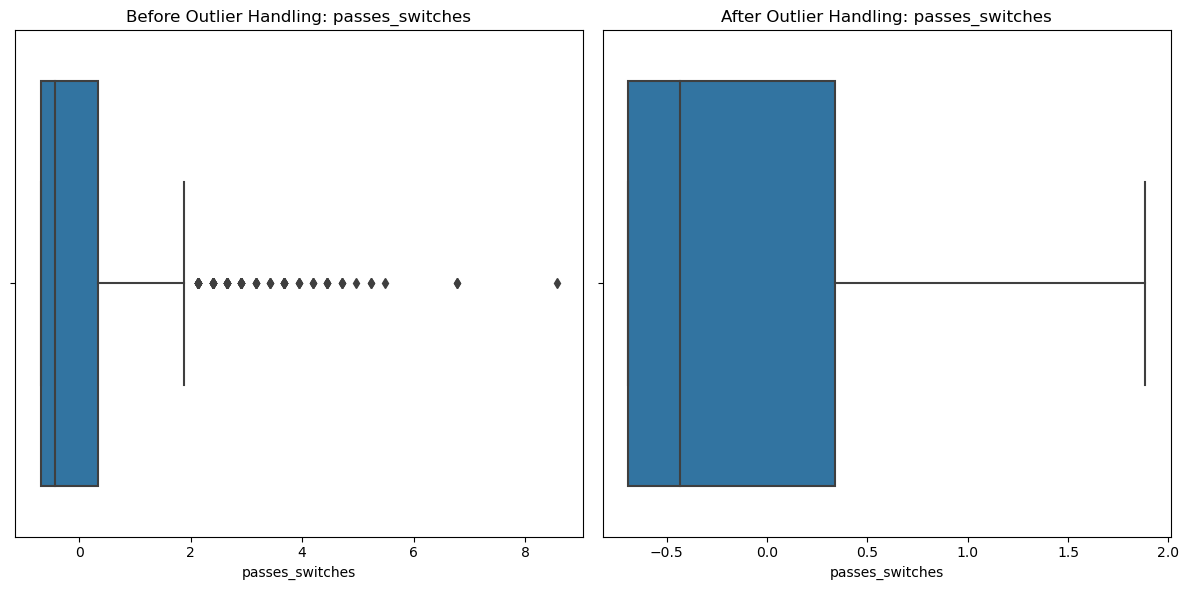

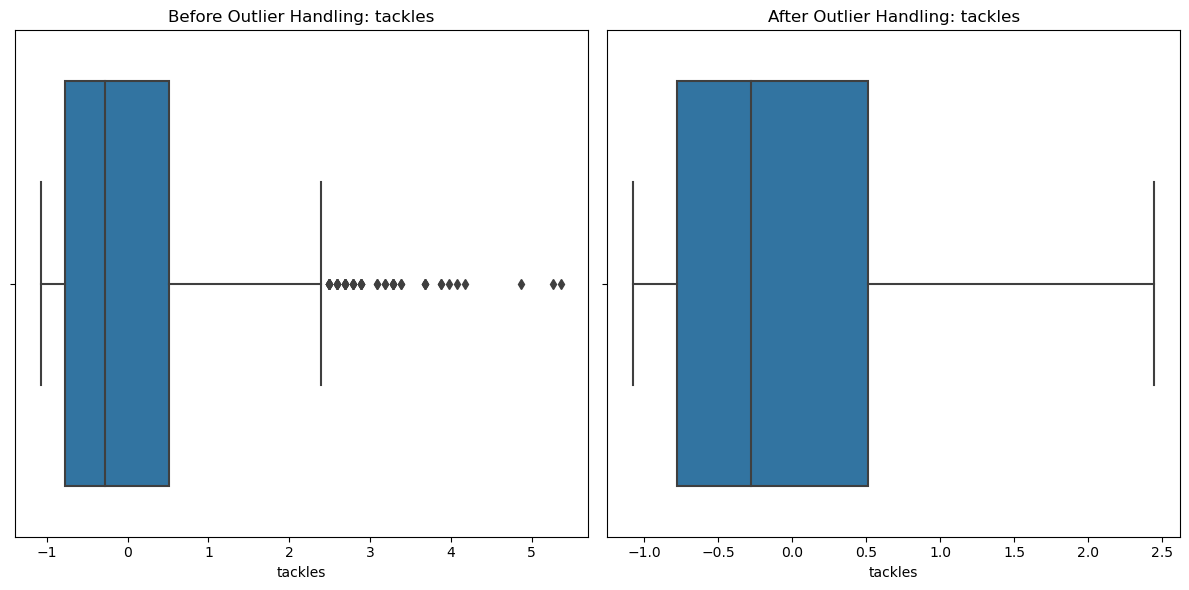

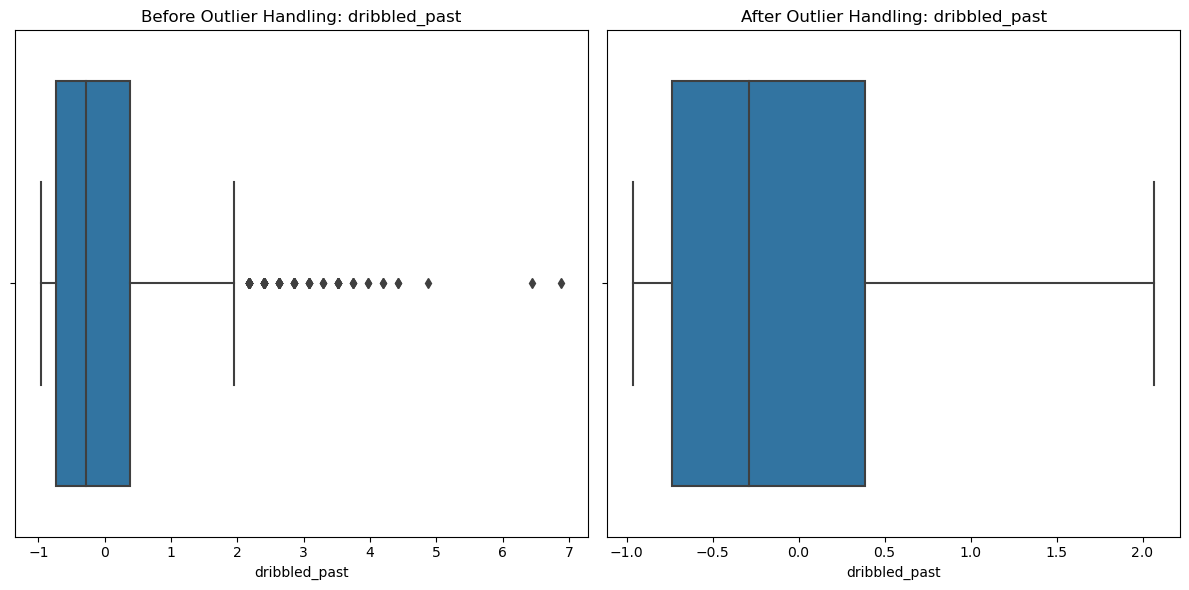

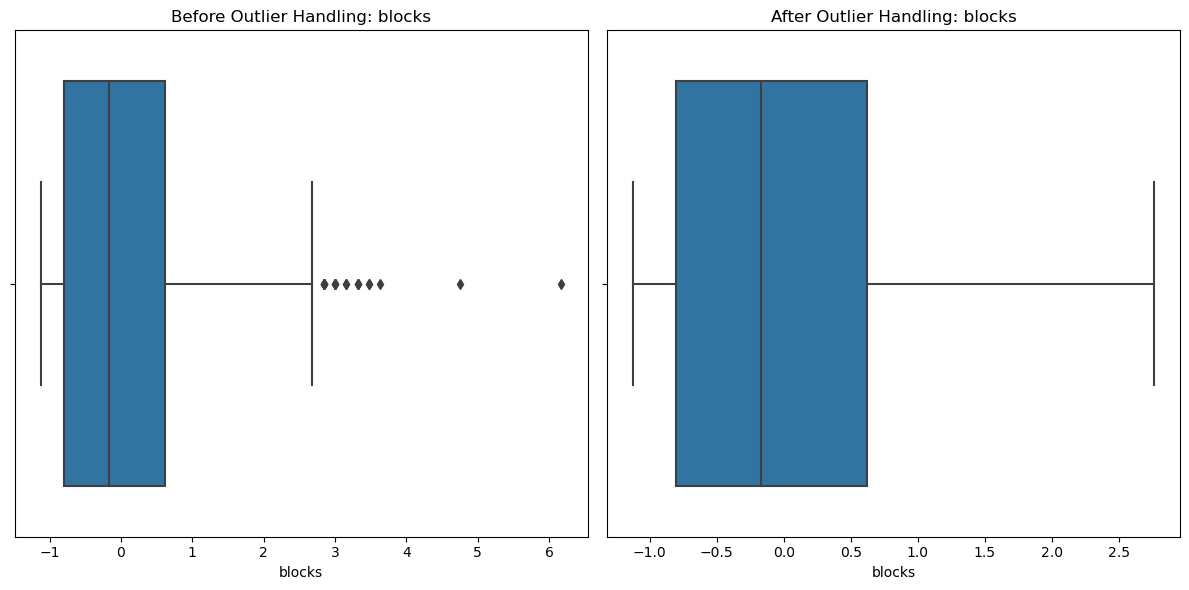

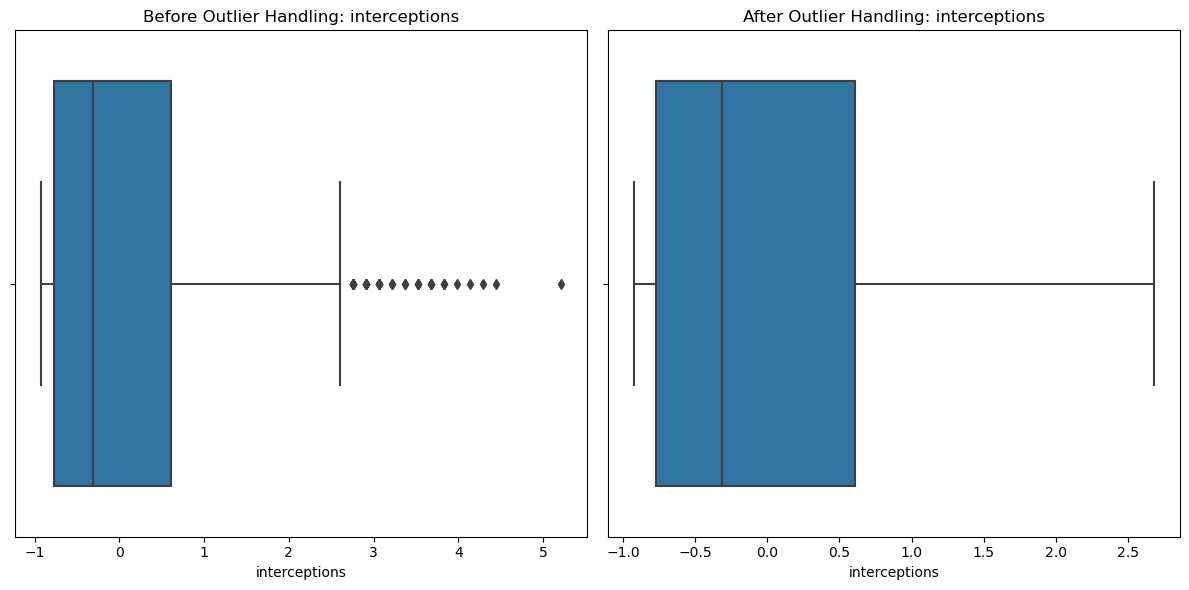

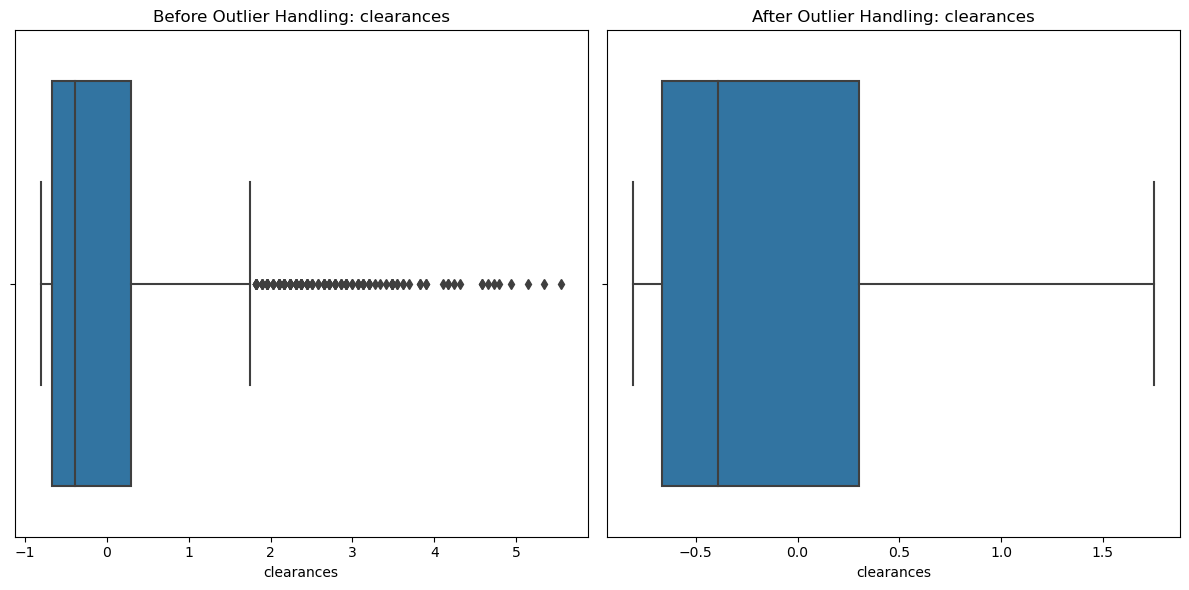

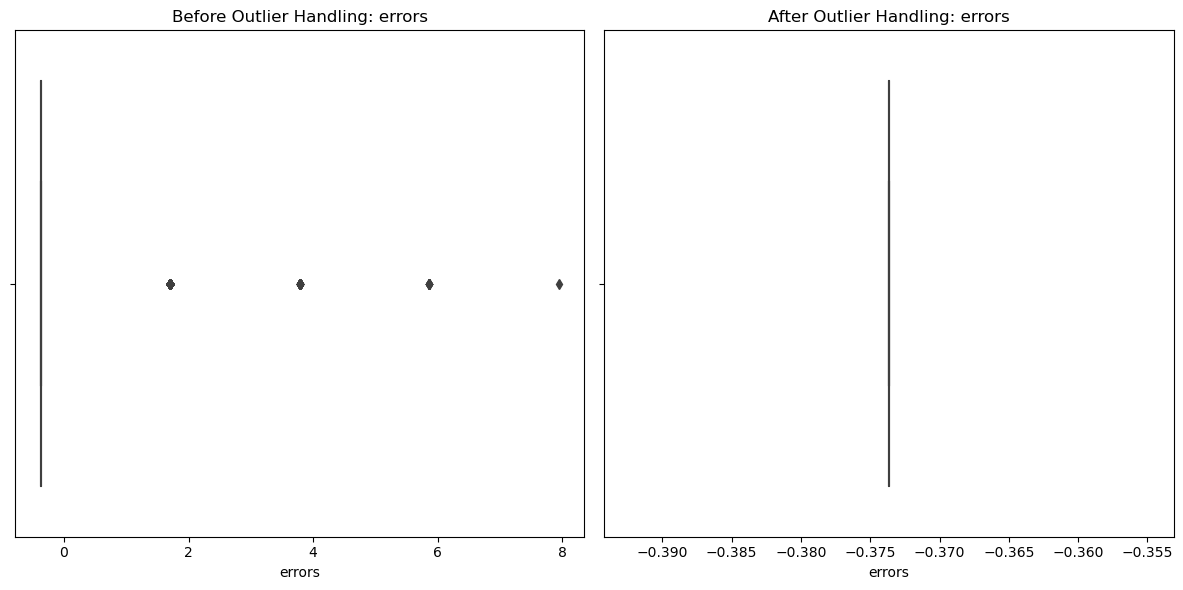

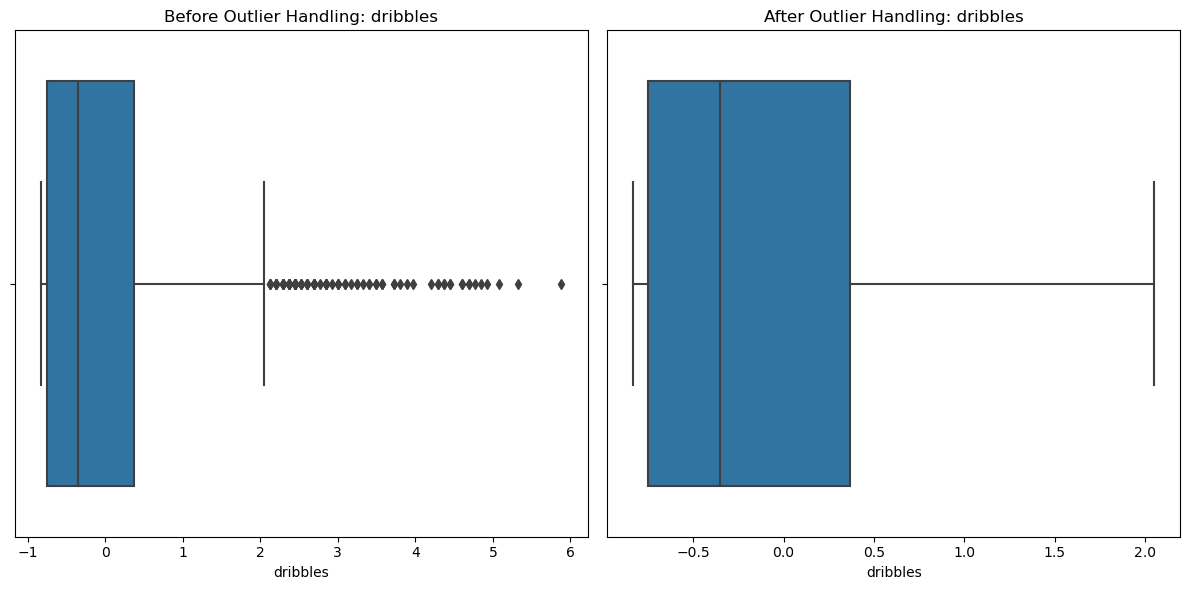

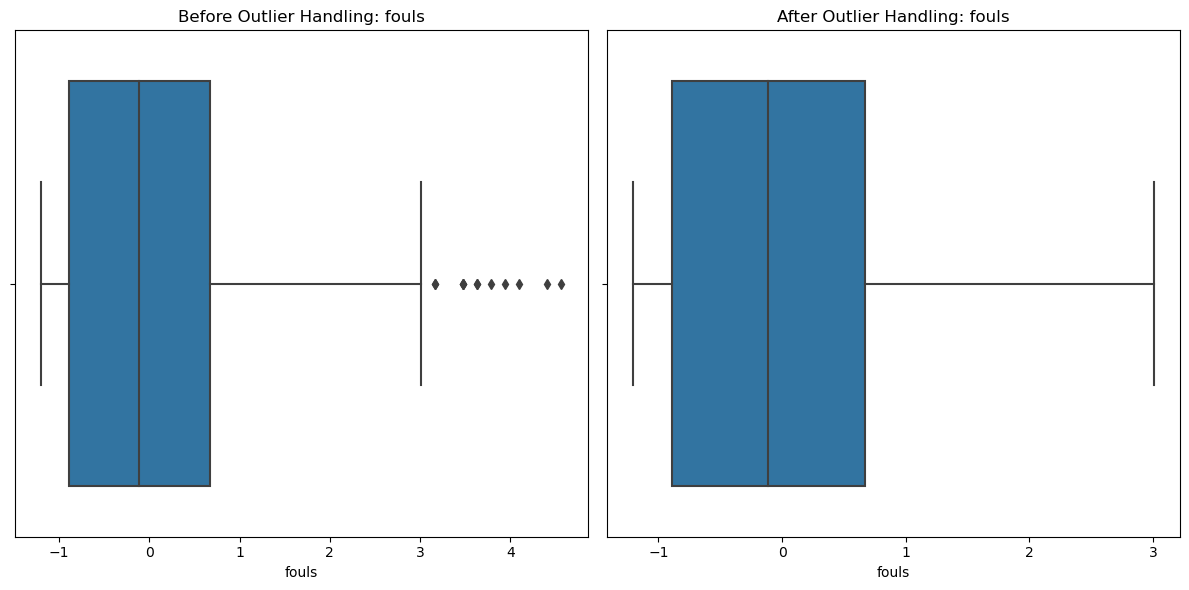

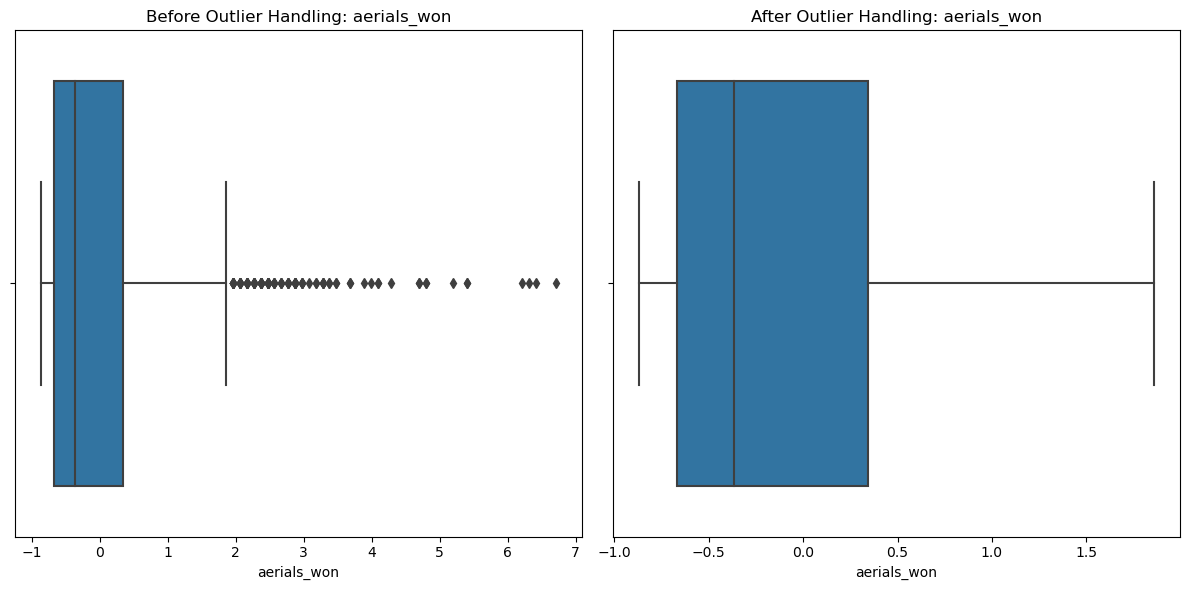

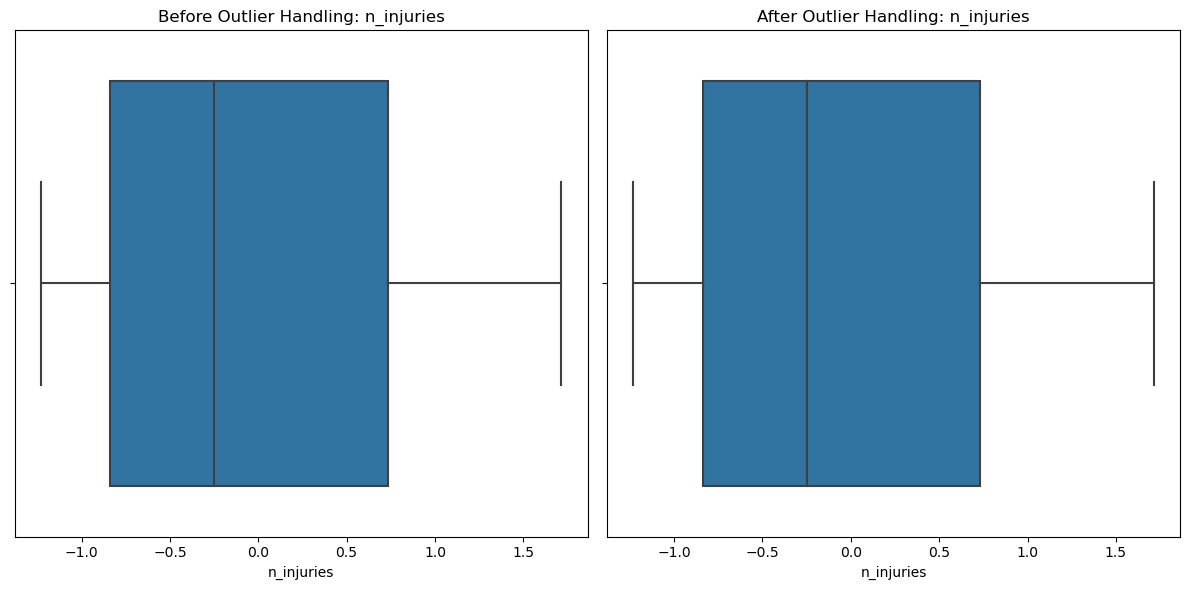

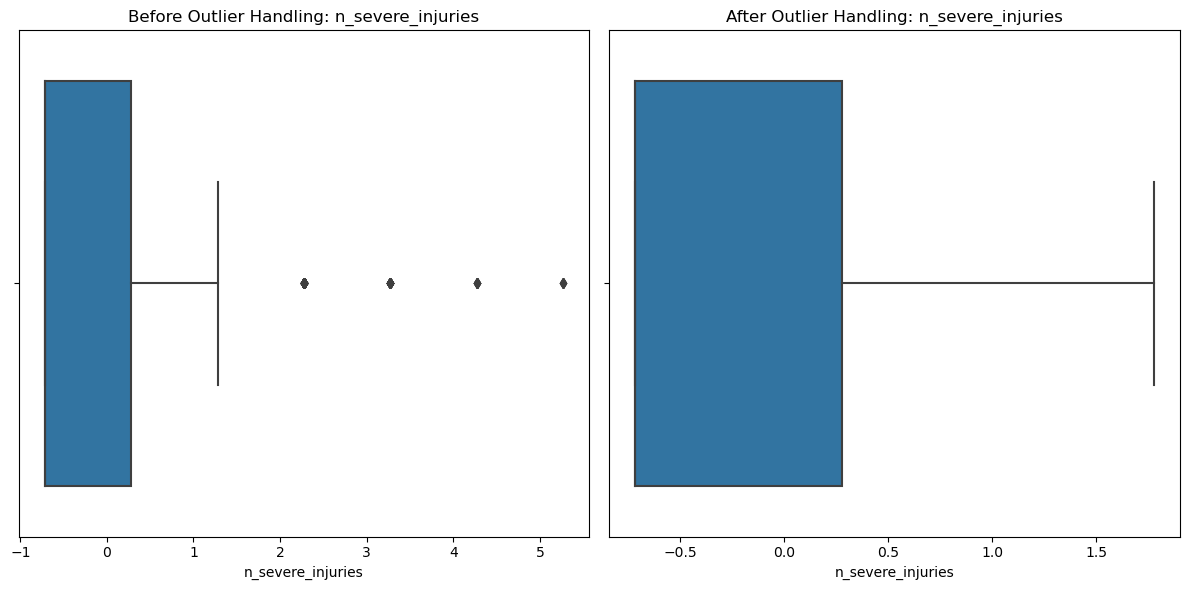

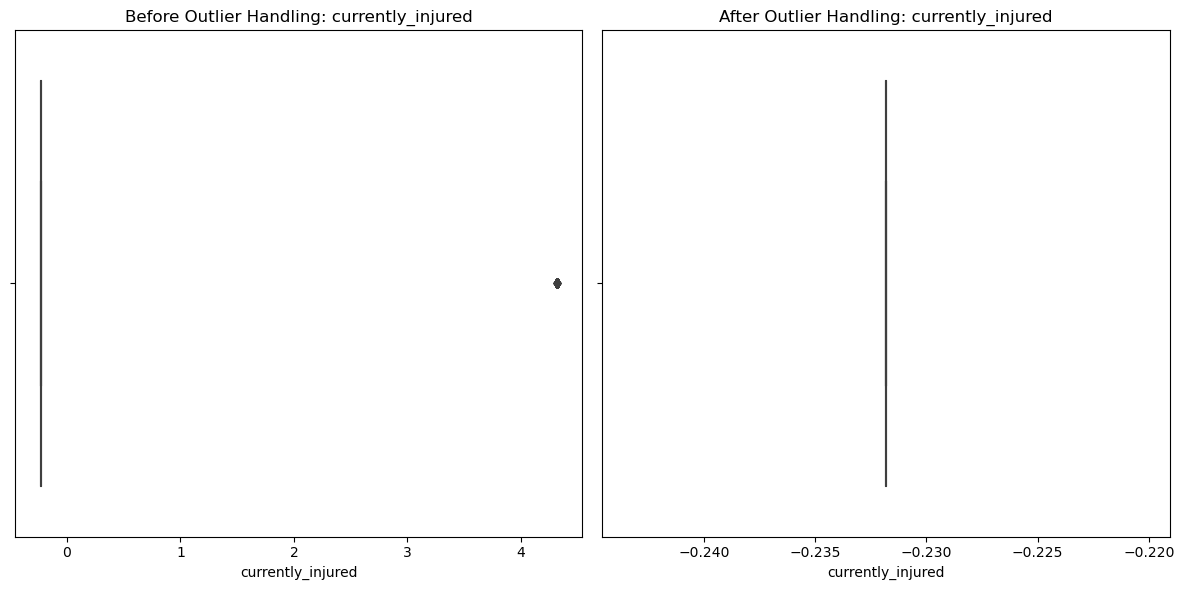

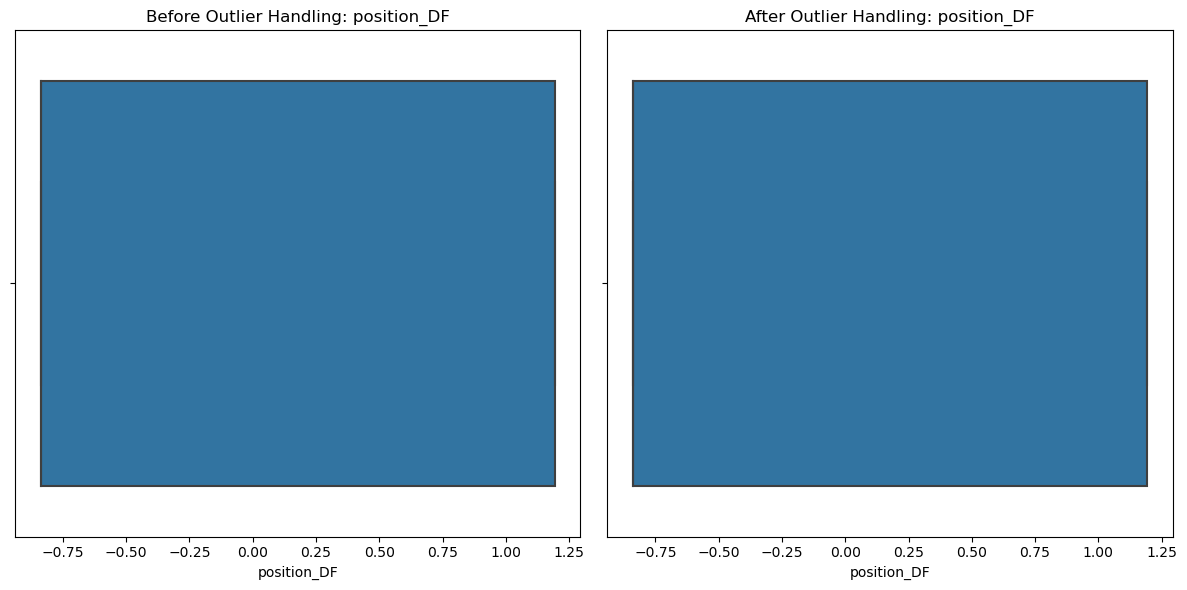

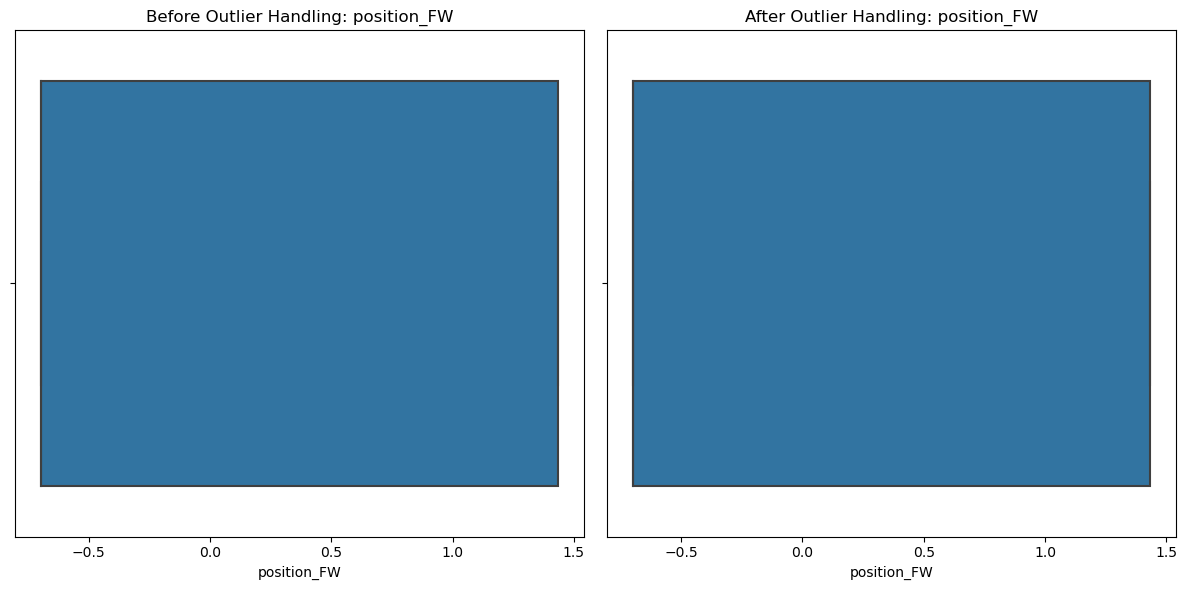

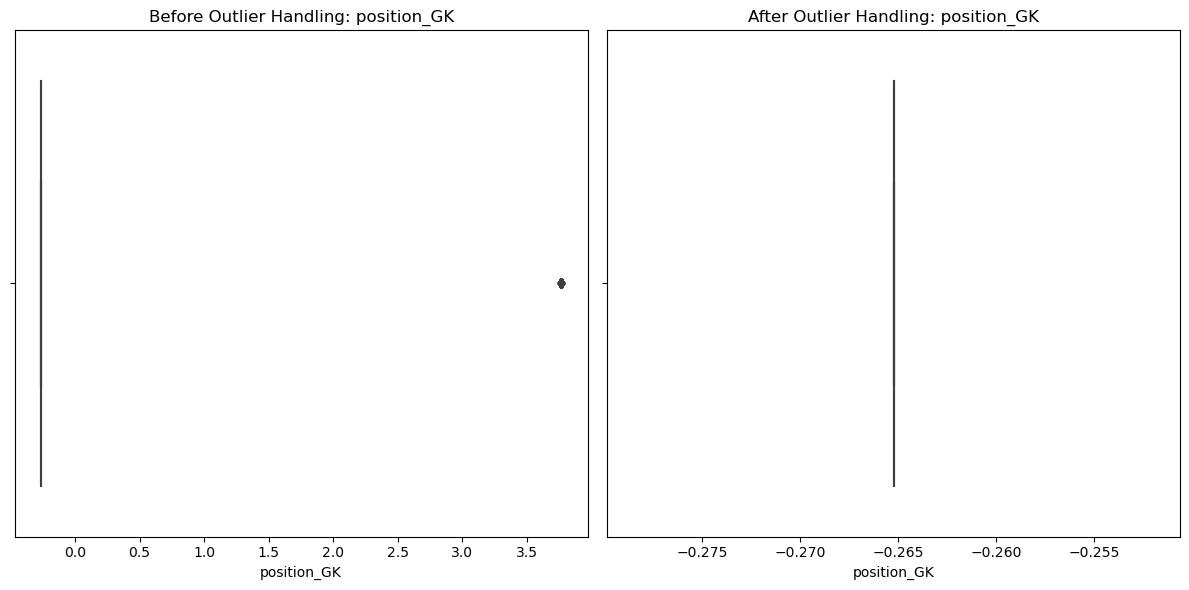

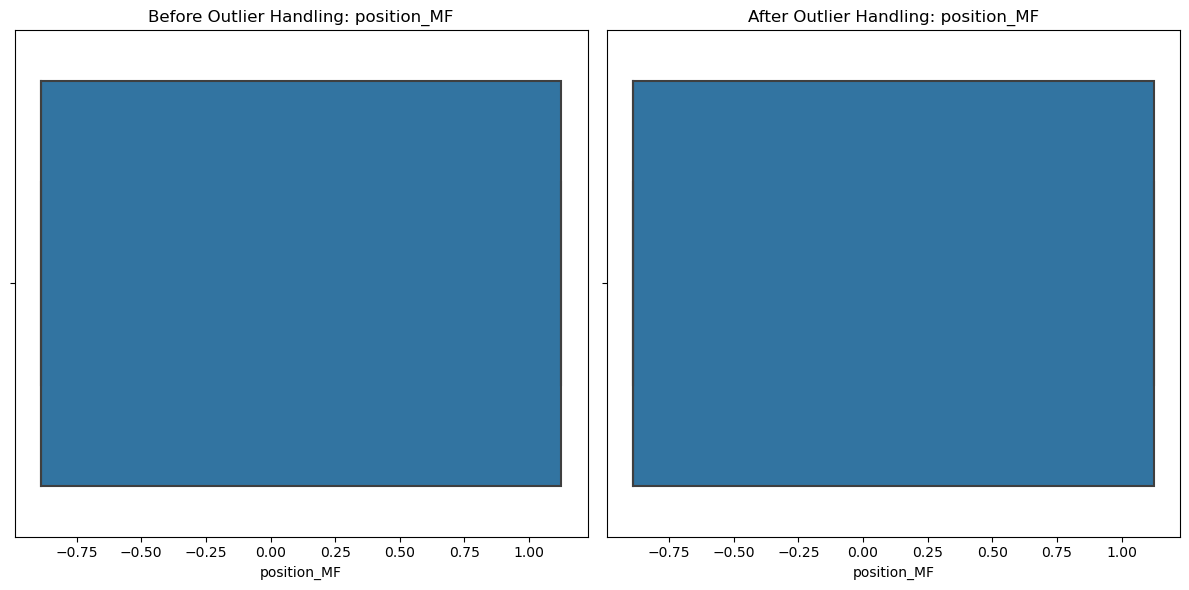

In [48]:


# Step 1: Capture Before and After Handling Data
# Use a copy of the dataset to capture the "before" state
football_data_before = football_data_cleaned.copy()

# Compute IQR and handle outliers as described earlier
Q1 = football_data_cleaned[numeric_cols].quantile(0.25)
Q3 = football_data_cleaned[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for col in numeric_cols:
    football_data_cleaned[col] = np.where(
        football_data_cleaned[col] < lower_bound[col], lower_bound[col],
        np.where(football_data_cleaned[col] > upper_bound[col], upper_bound[col], football_data_cleaned[col])
    )

# Step 2: Visualize Before and After Handling Outliers
for col in numeric_cols:
    plt.figure(figsize=(12, 6))

    # Before Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=football_data_before[col])
    plt.title(f'Before Outlier Handling: {col}')
    
    # After Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=football_data_cleaned[col])
    plt.title(f'After Outlier Handling: {col}')
    
    plt.tight_layout()
    plt.show()


### Handling Outliers

1. **Why Handle Outliers?**
   - Outliers can distort statistical analyses and model performance.
   - Extreme values affect metrics like mean and variance, biasing model predictions.

2. **How Are Outliers Handled?**
   - **Identify Outliers:** Compute the IQR (Interquartile Range) and define outliers as values below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
   - **Cap Outliers:** Replace values below the lower bound with the lower bound and values above the upper bound with the upper bound using `np.where`.

4. **Outcome:**
   - Reduced the influence of extreme values, ensuring robust statistical modeling and reliable insights.


# Injury Analysis using machine learning methods

this  step is to focus on feature extraction and build a model to predict injuries. Ideally, I aim to determine the importance of each feature through the model and identify the key factors contributing to injuries.

# Create a binary classification column

In [49]:
# Ensure working on football_data_cleaned
# Create binary classification column
football_data_cleaned['Injury_Binary'] = (football_data_cleaned['n_injuries'] >= 1).astype(int)

# Define features (X) and target (y)
X_football = football_data_cleaned.drop(columns=['n_injuries', 'Injury_Binary', 'Unnamed: 0', 'currently_injured', 'Position'], errors='ignore')
y_football = football_data_cleaned['Injury_Binary'].astype(int)






### Preparing Data for Injury Prediction in Football

1. **Binary Classification Column:**
   - **Purpose:** `Injury_Binary` column created to classify players as injured (`1`) or not injured (`0`), based on `n_injuries >= 1`.
   - **Why:** Focuses on the occurrence of injuries rather than the count, aligning with real-world use cases of identifying at-risk players.

2. **Benefits:**
   - Ensures a clean dataset by removing irrelevant and redundant features.
   - Focuses the analysis on relevant predictors for modeling injury occurrence.
   - Facilitates the development of binary classification models to predict injury risk effectively.


# Training and Test Set

In [50]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_football, y_football, test_size=0.2, random_state=42, stratify=y_football
)

### Train-Test Split for Model Training

1. **Purpose:**
   - Divides the data into training and testing sets to evaluate model performance on unseen data.
   - Ensures the model is trained on one subset and tested on another for generalizability.



2. **Outcome:**
   - **Training Set (`X_train_f`, `y_train_f`):** Used to fit the model and learn patterns.
   - **Test Set (`X_test_f`, `y_test_f`):** Reserved for evaluating the model’s performance on unseen data.

3 **Benefits:**
   - Improves model evaluation by mimicking real-world data scenarios.
   - Reduces the risk of overfitting by ensuring a separate validation set.
   - Preserves class balance for consistent and fair model training.


# OLS Regression

In [51]:
# Add constant for OLS regression
X_train_f_ols = sm.add_constant(X_train_f)

# Fit OLS model
ols_model = sm.OLS(y_train_f, X_train_f_ols).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          Injury_Binary   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     16.94
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           9.14e-58
Time:                        13:55:01   Log-Likelihood:                -618.86
No. Observations:                1521   AIC:                             1284.
Df Residuals:                    1498   BIC:                             1406.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
age               

### 2. **Football OLS Regression Results**
- **Dependent Variable**: Injury Binary (Injury occurrence: 0 or 1)
- **R-squared**: 0.199, indicating that the model explains approximately 19.9% of the variance in injury occurrence.
- **Key Variables**:
  - **Age**: Coefficient of 0.1259, highly significant (p-value < 0.0001), suggesting that older players are more likely to get injured.
  - **Games Played**: Coefficient of 0.0127, not statistically significant (p-value = 0.556), indicating that the number of games played does not have a strong effect on injury likelihood.
  - **Minutes Played**: Coefficient of -0.0981, statistically significant (p-value = 0.005), showing that more minutes played slightly decreases the probability of injury.
  - **Passes and Shots**: Several passing metrics, such as passes completed and passes long, as well as shooting metrics, show significant relationships, indicating that player activity (e.g., passing and shooting) could influence the likelihood of injury.
  - **Position**: The variables for "position_FW" (Forward) and "position_GK" (Goalkeeper) are significant, suggesting that players in these positions may have a higher likelihood of injury compared to other positions.


### Comparison Between Football and Basketball OLS Models: Significant Variables

#### Football
- **Age**: Not significant for predicting injuries.  
- **Games Played**: Weak negative correlation (-0.0758), not statistically significant.  
- **Minutes Played**: Slight positive correlation (p-value = 0.006), indicating a minor increase in injury risk with more minutes played.  
- **Position**: "Forward" and "Goalkeeper" are weakly significant, slightly influencing injury likelihood.  

#### Basketball
- **Age**: Highly significant (coefficient = 0.1259, p-value < 0.0001), with older players at higher injury risk.  
- **Games Played**: No significant impact (p-value = 0.556).  
- **Minutes Played**: Weak negative correlation (p-value = 0.005), suggesting fewer injuries with more minutes played.  
- **Performance Metrics**: Variables like passes completed and shots are significant, showing that higher activity levels increase injury risk.  
- **Position**: "Forward" and "Goalkeeper" positions significantly affect injury likelihood.  


# logistic regression

In [52]:
start_time = time.time()
log_reg_f = LogisticRegression(max_iter=1000, random_state=42)
log_reg_f.fit(X_train_f, y_train_f)
y_pred_log_f = log_reg_f.predict(X_test_f)
y_proba_log_f = log_reg_f.predict_proba(X_test_f)[:, 1]
log_roc_auc_f = roc_auc_score(y_test_f, y_proba_log_f)
end_time = time.time()

print(f"\nLogistic Regression ROC AUC: {log_roc_auc_f:.2f}")
print(f"Time Taken: {end_time - start_time:.2f} seconds")
print(classification_report(y_test_f, y_pred_log_f))


Logistic Regression ROC AUC: 0.83
Time Taken: 0.08 seconds
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       302
           1       0.69      0.32      0.43        79

    accuracy                           0.83       381
   macro avg       0.77      0.64      0.67       381
weighted avg       0.81      0.83      0.80       381



# Random Forest

In [53]:
# Step 6: Random Forest
start_time = time.time()
rf_f = RandomForestClassifier(n_estimators=100, random_state=42)
rf_f.fit(X_train_f, y_train_f)
y_pred_rf_f = rf_f.predict(X_test_f)
y_proba_rf_f = rf_f.predict_proba(X_test_f)[:, 1]
rf_roc_auc_f = roc_auc_score(y_test_f, y_proba_rf_f)
end_time = time.time()
print(f"\nRandom Forest ROC AUC: {rf_roc_auc_f:.2f}")
print(f"Time Taken: {end_time - start_time:.2f} seconds")
print(classification_report(y_test_f, y_pred_rf_f))


Random Forest ROC AUC: 0.77
Time Taken: 0.29 seconds
              precision    recall  f1-score   support

           0       0.82      0.97      0.88       302
           1       0.57      0.16      0.25        79

    accuracy                           0.80       381
   macro avg       0.69      0.57      0.57       381
weighted avg       0.76      0.80      0.75       381



# Support Vector Machine (SVM)

In [54]:
# Step 5: SVM
start_time = time.time()
svm_f = SVC(probability=True, random_state=42)
svm_f.fit(X_train_f, y_train_f)
y_pred_svm_f = svm_f.predict(X_test_f)
y_proba_svm_f = svm_f.predict_proba(X_test_f)[:, 1]
svm_roc_auc_f = roc_auc_score(y_test_f, y_proba_svm_f)
end_time = time.time()
print(f"\nSVM ROC AUC: {svm_roc_auc_f:.2f}")
print(f"Time Taken: {end_time - start_time:.2f} seconds")
print(classification_report(y_test_f, y_pred_svm_f))


SVM ROC AUC: 0.75
Time Taken: 0.52 seconds
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       302
           1       0.73      0.10      0.18        79

    accuracy                           0.81       381
   macro avg       0.77      0.55      0.53       381
weighted avg       0.79      0.81      0.74       381



# XGBoost

In [55]:
# Step 7: XGBoost
start_time = time.time()
xgb_f = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_f.fit(X_train_f, y_train_f)
y_pred_xgb_f = xgb_f.predict(X_test_f)
y_proba_xgb_f = xgb_f.predict_proba(X_test_f)[:, 1]
xgb_roc_auc_f = roc_auc_score(y_test_f, y_proba_xgb_f)
end_time = time.time()
print(f"\nXGBoost ROC AUC: {xgb_roc_auc_f:.2f}")
print(f"Time Taken: {end_time - start_time:.2f} seconds")
print(classification_report(y_test_f, y_pred_xgb_f))

/Users/mengfanlong/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



XGBoost ROC AUC: 0.75
Time Taken: 0.29 seconds
              precision    recall  f1-score   support

           0       0.83      0.91      0.86       302
           1       0.43      0.27      0.33        79

    accuracy                           0.77       381
   macro avg       0.63      0.59      0.60       381
weighted avg       0.74      0.77      0.75       381



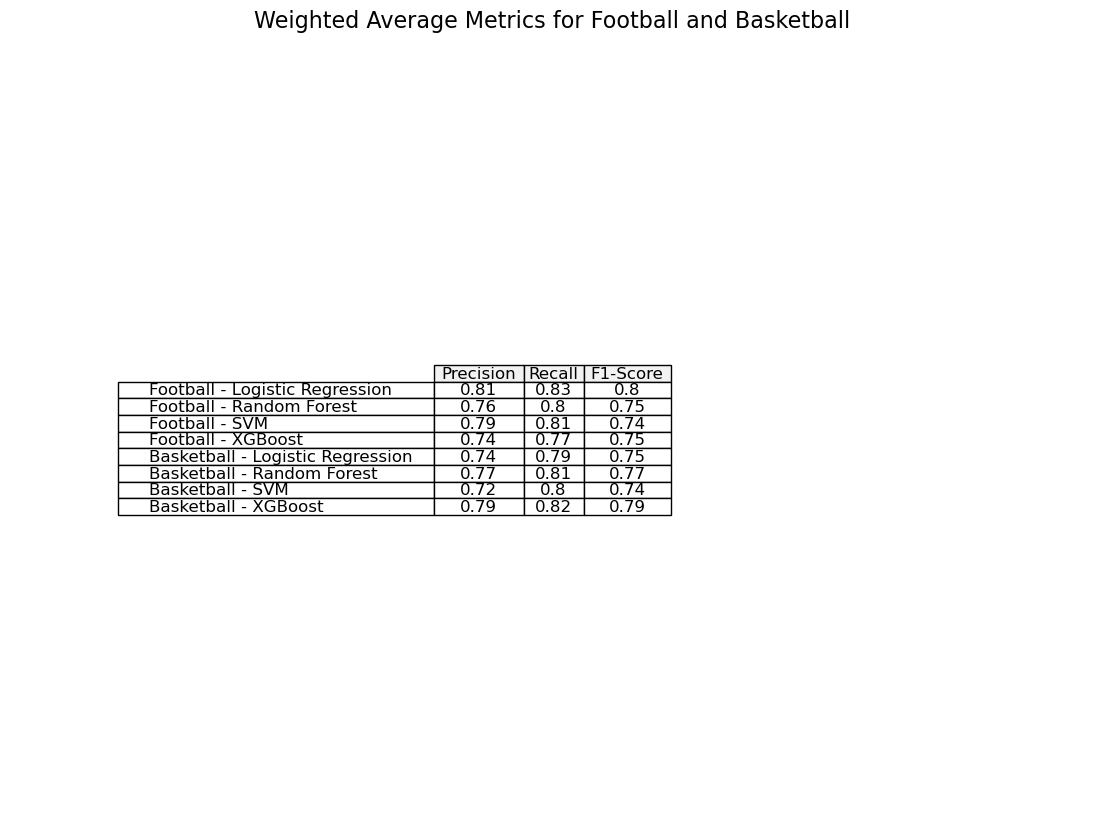

In [56]:


# Data for Football (Weighted Avg values)
football_data = {
    'Precision': [0.81, 0.76, 0.79, 0.74],
    'Recall': [0.83, 0.80, 0.81, 0.77],
    'F1-Score': [0.80, 0.75, 0.74, 0.75]
}
football_methods = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']
df_football = pd.DataFrame(football_data, index=football_methods)

# Data for Basketball (Weighted Avg values)
basketball_data = {
    'Precision': [0.74, 0.77, 0.72, 0.79],
    'Recall': [0.79, 0.81, 0.80, 0.82],
    'F1-Score': [0.75, 0.77, 0.74, 0.79]
}
basketball_methods = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']
df_basketball = pd.DataFrame(basketball_data, index=basketball_methods)

# Combine football and basketball data into one table plot
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('tight')
ax.axis('off')

# Combine the data
combined_data = pd.concat([df_football, df_basketball], axis=0, keys=["Football", "Basketball"])
row_labels = [
    f"Football - {method}" if idx == "Football" else f"Basketball - {method}" 
    for idx, method in combined_data.index
]

# Create the table
table = ax.table(
    cellText=combined_data.round(2).values,
    colLabels=combined_data.columns,
    rowLabels=row_labels,
    loc='center',
    cellLoc='center',
    colColours=["#f2f2f2"] * combined_data.shape[1]  # Light gray column headers
)

# Set table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(combined_data.columns))))

# Set the plot title
ax.set_title("Weighted Average Metrics for Football and Basketball", fontsize=16, pad=20)

# Show the plot
plt.show()


### Summary

### Key Variables Influencing Injuries in Football and Basketball

#### Football
- **Minutes Played**: Weakly significant (p-value = 0.006); more minutes slightly increase injury risk.
- **Position**: "Forward" and "Goalkeeper" positions show weak significance for injury likelihood.

#### Basketball
- **Age**: Highly significant (p-value < 0.0001); older players are at higher injury risk.
- **Minutes Played**: Weak negative correlation (p-value = 0.005); more minutes played may reduce injury risk.
- **Performance Metrics**: Activity levels (e.g., passes completed, shots) significantly increase injury risk.
- **Position**: "Forward" and "Goalkeeper" positions strongly influence injury likelihood.


# Model performance

## Football Data
- **Logistic Regression**:
  - **Precision**: 0.81
  - **Recall**: 0.83
  - **F1-Score**: 0.80
  - Logistic Regression shows strong predictive power and a good balance across metrics, making it the best-performing model for football.

- **Random Forest**:
  - **Precision**: 0.76
  - **Recall**: 0.80
  - **F1-Score**: 0.75
  - Random Forest performs well but is slightly less effective than Logistic Regression.

- **SVM**:
  - **Precision**: 0.79
  - **Recall**: 0.81
  - **F1-Score**: 0.74
  - SVM achieves a good balance of precision and recall but has a lower F1-Score compared to other models.

- **XGBoost**:
  - **Precision**: 0.74
  - **Recall**: 0.77
  - **F1-Score**: 0.75
  - XGBoost performs similarly to Random Forest but slightly lags in both recall and precision.

---

## Basketball Data
- **Logistic Regression**:
  - **Precision**: 0.74
  - **Recall**: 0.79
  - **F1-Score**: 0.75
  - Logistic Regression performs consistently but struggles with injury detection compared to non-injuries.

- **Random Forest**:
  - **Precision**: 0.77
  - **Recall**: 0.81
  - **F1-Score**: 0.77
  - Random Forest outperforms Logistic Regression slightly in recall and F1-Score, making it a strong contender for basketball.

- **SVM**:
  - **Precision**: 0.72
  - **Recall**: 0.80
  - **F1-Score**: 0.74
  - SVM delivers a good recall but lower precision and F1-Score compared to Random Forest.

- **XGBoost**:
  - **Precision**: 0.79
  - **Recall**: 0.82
  - **F1-Score**: 0.79
  - XGBoost is the best-performing model for basketball, with the highest F1-Score and recall, demonstrating strong injury detection capability.

---

## Overall Comparison
- **Best Models**:
  - **Football**: Logistic Regression stands out with the best balance of precision, recall, and F1-Score.
  - **Basketball**: XGBoost is the top performer, followed closely by Random Forest.

- **Model Strengths**:
  - Logistic Regression is computationally efficient and reliable for both datasets.
  - XGBoost is particularly effective for basketball, showing the highest recall and F1-Score.

- **Challenges**:
  - All models face difficulties detecting injured players (class 1), as reflected in generally lower recall values for this class.


### Overall Conclusion
This study explores data from both football and basketball to identify common and sport-specific factors contributing to injuries, such as workload, game conditions, and player attributes. By leveraging diagrams and linear regression for preliminary analysis, we find that basketball data offers stronger explanatory power for injury likelihood, with clearer patterns in variables like age and position. In football, the factors influencing injuries are less pronounced, and the model is less informative. Nonetheless, both datasets suggest that workload, age, and position are key factors in understanding injury risks across sports.



# Future Improvements can be implemented


- **Data Collection**: Expand the dataset by including additional variables such as training intensity, recovery times, injury severity, and environmental factors like weather conditions to provide a more comprehensive view of injury risks.
- **Advanced Modeling**: Leverage advanced machine learning algorithms (e.g., Random Forest, Gradient Boosting, Neural Networks) to better capture complex relationships and improve prediction accuracy.
- **Feature Engineering**: Create derived features like cumulative workload, injury rates per game, or player-specific fatigue indices to enhance the model's ability to predict injury likelihood.
- **Class Imbalance Handling**: Employ techniques such as SMOTE (Synthetic Minority Oversampling Technique) or cost-sensitive learning to address the imbalance in injury data and improve model performance for underrepresented classes (e.g., injured players).
- **Longitudinal and Time-Series Analysis**: Conduct longitudinal studies or apply time-series modeling to assess injury risk patterns over multiple seasons, enabling more robust predictions and actionable insights.
- **Sport-Specific Analysis**: Tailor models to the unique characteristics and demands of each sport, such as differentiating between contact and non-contact sports or incorporating position-specific workload metrics.
- **Real-Time Monitoring**: Integrate wearable technology data (e.g., heart rate, GPS tracking) for real-time monitoring of player workload and fatigue, enabling proactive injury prevention measures.
